## Domain adaptation

In [385]:
import datetime
import fasttext
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import os
import pandas as pd
import pickle
import random
import re
import scipy.stats
import uuid
from nltk.tokenize import TweetTokenizer
from IPython.display import clear_output

In [3]:
DATADIR = "../data/"
ANNOTATION_DIR = DATADIR + "annotation/"
DISTANCE = "distance"
FACEMASK = "mondkapje"
TESTING = "testing"
VACCINATION = "vaccin"
FILEFASTTEXT = "fasttext.csv"
IDSTR = "id_str"
IRRELEVANT = "IRRELEVANT"
NEUTRAL = "NEUTRAL"
ANDERS = "ANDERS"
EENS = "EENS"
ONEENS = "ONEENS"
SUPPORTS = "SUPPORTS"
REJECTS = "REJECTS"
LABEL = "label"
TEXT = "text"
USER = "user"
LABELPREFIX = "__label__"
LARGEINT = 9999999999

In [4]:
DIM = 300
EPOCH = 200
LR = 0.2
N = 10
TRAIN = "TRAIN"+str(int(random.random()*LARGEINT))
TEST = "TEST"+str(int(random.random()*LARGEINT))
VALIDATION = "VALIDATION"+str(int(random.random()*LARGEINT))

In [416]:
def cleanup(text):
    text = re.sub(r"\\n"," ",text)
    text = re.sub(r"https://\S+","",text)
    text = re.sub(r"\s+"," ",text)
    text = text.strip()
    return(text)


def tokenize(text):
    return(" ".join(TweetTokenizer().tokenize(text)))


def preprocess(text):
    return(tokenize(cleanup(text)).lower())


def select_annotations(tweets, annotations, target_annotator):
    fasttext_data = {}
    for i in range(0,len(annotations)):
        annotator = annotations.iloc[i][0]
        tweet_id = annotations.iloc[i][2]
        if annotator == target_annotator and tweet_id in list(tweets.index):
            tweet_user = tweets.loc[tweet_id][1]
            tweet_label = annotations.iloc[i][4]
            if tweet_label == NEUTRAL: tweet_label = IRRELEVANT
            if tweet_label == ANDERS: tweet_label = IRRELEVANT
            if tweet_label == EENS: tweet_label = SUPPORTS
            if tweet_label == ONEENS: tweet_label = REJECTS
            fasttext_data[tweet_id] = { LABEL:LABELPREFIX+tweet_label,
                                        USER:tweet_user,
                                        TEXT:preprocess(tweets.loc[tweet_id][TEXT]) }
    return({tweet_id: fasttext_data[tweet_id] for tweet_id in sorted(fasttext_data.keys())})


def store_fasttext_data_fixed(fasttext_data):
    outfile = open(FILEFASTTEXT, "w")
    seen_texts = {}
    fasttext_data_list = []
    tweet_ids = []
    for tweet_id in fasttext_data:
        text = cleanup(fasttext_data[tweet_id][TEXT])
        if not text in seen_texts:
            print(fasttext_data[tweet_id][LABEL], text, file=outfile)
            fasttext_data_list.append(" ".join([fasttext_data[tweet_id][LABEL], text]))
            tweet_ids.append(tweet_id)
            seen_texts[text] = True
    outfile.close()
    return(fasttext_data_list, tweet_ids)

In [417]:
def make_fasttext_data(topic):
    if topic == TESTING:
        tweet_file = ANNOTATION_DIR + topic + "-202003-202012.csv"
    elif topic == FACEMASK:
        tweet_file = ANNOTATION_DIR + topic + "-202003-202103-1000.csv"
    elif topic == VACCINATION:
        tweet_file = ANNOTATION_DIR + topic + "-202001-202101-1000.csv"
    elif topic == DISTANCE:
        tweet_file = DATADIR + topic + "-tweets.csv"
    else:
        print(f"make_fasttext_data: cannot happen! ({topic})")
    tweets = pd.read_csv(tweet_file, index_col=IDSTR)
    annotations = pd.read_csv(tweet_file + ".human-labels.txt", header=None, sep=" ")        
    main_annotator = annotations.iloc[0][0]
    fasttext_data = select_annotations(tweets, annotations, main_annotator)
    fasttext_data_list, tweet_ids = store_fasttext_data_fixed(fasttext_data)
    return(fasttext_data_list, tweet_ids)

In [481]:
def makeConfusionMatrix(fasttextData,predictionLabels):
    goldLabels = pd.Series([fasttextData[i].split()[0] for i in range(0,len(fasttextData))])
    predictedLabels = pd.Series([x[0] for row in predictionLabels for x in row[0]])
    return(pd.crosstab(goldLabels,predictedLabels))

def evaluate(predictionCounts,predictionLabels,fasttextData,printResults=True,printMatrix=False):
    caseTotal = 0
    pTotal = 0
    rTotal = 0
    for i in range(0,len(predictionCounts)):
        caseTotal += predictionCounts[i][0]
        pTotal += predictionCounts[i][0]*predictionCounts[i][1]
        rTotal += predictionCounts[i][0]*predictionCounts[i][2]
    precision = round(pTotal/caseTotal,3)
    recall = round(rTotal/caseTotal,3)
    try:
        cf = makeConfusionMatrix(fasttextData,predictionLabels)
        if printMatrix:
            print(cf)
        for label in ['__label__REJECTS','__label__SUPPORTS','__label__IRRELEVANT']:
            if not label in cf: cf[label] = [0 for i in range(0,len(cf))]
        numberOfPredictedSupportLabels = sum([cf.iloc[i]['__label__SUPPORTS'] for i in range(0,len(cf))])
        numberOfGoldSupportLabels = sum(cf.loc['__label__SUPPORTS'])
        numberOfPredictedRejectLabels = sum([cf.iloc[i]['__label__REJECTS'] for i in range(0,len(cf))])
        numberOfGoldRejectLabels = sum(cf.loc['__label__REJECTS'])
        if numberOfPredictedSupportLabels > 0 and numberOfGoldRejectLabels > 0 and numberOfGoldSupportLabels > 0:
            fraction = (numberOfPredictedRejectLabels/numberOfPredictedSupportLabels)/(numberOfGoldRejectLabels/numberOfGoldSupportLabels)
        else:
            fraction = LARGEINT
    except:
        fraction = 0
    if printResults: 
        print("cases: {0}; precision: {1:0.3f}; recall: {2:0.3f}; fraction: {3:0.3f}".format(caseTotal,precision,recall,fraction))
    return((precision,fraction))

def runFasttext(fasttextData1, fasttextData2, dim=DIM, epoch=EPOCH, lr=LR, n=N, squealFlag=True, maxTrain=None, pretrainedVectors=None):
    print(f"data size 1={len(fasttextData1)}, data size 2={len(fasttextData2)}, dim={dim}, epoch={epoch}, lr={lr}, pretrainedVectors={pretrainedVectors}")
    predictionCountsTest = []
    predictionLabelsTest = []
    predictionCountsValidation = []
    predictionLabelsValidation = []
    for fold in range(0,n):
        if squealFlag:
            clear_output(wait=True)
            print("starting fold",fold)
        testStart1 = round(fold*len(fasttextData1)/n)
        testEnd1 = round((fold+1)*len(fasttextData1)/n)
        testStart2 = round(fold*len(fasttextData2)/n)
        testEnd2 = round((fold+1)*len(fasttextData2)/n)
        if fold < n-1: nextFold = fold+1
        else: nextFold = 0
        validationStart1 = round(nextFold*len(fasttextData1)/n)
        validationEnd1 = round((nextFold+1)*len(fasttextData1)/n)
        validationStart2 = round(nextFold*len(fasttextData2)/n)
        validationEnd2 = round((nextFold+1)*len(fasttextData2)/n)
        trainFile = open(TRAIN,"w")
        testFile = open(TEST,"w")
        validationFile = open(VALIDATION,"w")
        trainData = []
        validationData = []
        testData = []
        for i in range(0,len(fasttextData1)):
            data = fasttextData1[i]
            if i >= testStart1 and i < testEnd1: 
                pass
            elif i >= validationStart1 and i < validationEnd1: 
                pass
            else: 
                print(data,file=trainFile)
                trainData.append(data)
        for i in range(0,len(fasttextData2)):
            data = fasttextData2[i]
            if i >= testStart2 and i < testEnd2: 
                print(data,file=testFile)
                testData.append(data)
            elif i >= validationStart2 and i < validationEnd2: 
                print(data,file=validationFile)
                validationData.append(data)
        testFile.close()
        trainFile.close()
        validationFile.close()
        if not maxTrain == None and maxTrain < len(trainData):
            trainData = ranSelect(trainData,maxTrain)
            trainFile = open(TRAIN,"w")
            for i in range(0,len(trainData)):
                print(trainData[i],file=trainFile)
            trainFile.close()
        if pretrainedVectors == None:
            model = fasttext.train_supervised(TRAIN, dim=dim, epoch=epoch, lr=lr)
        else:
            model = fasttext.train_supervised(TRAIN, dim=dim, epoch=epoch, lr=lr, pretrainedVectors=pretrainedVectors)
        predictionCountsValidation.append([*model.test(VALIDATION)])
        predictionLabelsValidation.append(model.predict(validationData, k=3))
        predictionCountsTest.append([*model.test(TEST)])
        predictionLabelsTest.append(model.predict(testData, k=3))
        print(fold, end=" ")
        evaluate([[*model.test(TEST)]], [model.predict(testData)], fasttextData2[testStart2:testEnd2])
        os.unlink(TRAIN)
        os.unlink(TEST)
        os.unlink(VALIDATION)
    print("", end=" ")
    precision, fraction = evaluate(predictionCountsTest, predictionLabelsTest, fasttextData2, printMatrix=True)
    if squealFlag:
        clear_output(wait=True)
        print("finished")
    return(predictionCountsValidation, predictionLabelsValidation, predictionCountsTest, predictionLabelsTest, precision)

In [418]:
fasttext_data_list_distance, tweet_ids_distance = make_fasttext_data(DISTANCE)
fasttext_data_list_facemask, tweet_ids_facemask = make_fasttext_data(FACEMASK)
fasttext_data_list_testing, tweet_ids_testing = make_fasttext_data(TESTING)
fasttext_data_list_vaccination, tweet_ids_vaccination = make_fasttext_data(VACCINATION)

In [9]:
len(tweet_ids_distance), len(tweet_ids_facemask), len(tweet_ids_testing), len(tweet_ids_vaccination)

(5731, 1011, 1181, 1007)

In [10]:
def store_fasttext_data(data, file_name):
    with open(file_name, "wb") as outfile:
        pickle.dump(data, outfile)
        outfile.close()
        
def read_fasttext_data(file_name):
    with open(file_name, "rb") as infile:
        data = pickle.load(infile)
        infile.close()
    return(data)

## 1. Evaluation within domains (TGTONLY)

In [90]:
def get_prediction_labels_list(prediction_labels_10cv):
    prediction_labels = []
    for i in range(0, len(prediction_labels_10cv)):
        prediction_labels.extend([row[0] for row in prediction_labels_10cv[i][0]])
    return prediction_labels


def compute_accuracy(prediction_labels, fasttext_data_list):
    correct = 0
    for i in range(0, len(fasttext_data_list)):
        gold_label = fasttext_data_list[i].split(" ")[0]
        if prediction_labels[i] == gold_label:
            correct += 1
    return(round(correct / len(fasttext_data_list), 3))

In [460]:
predictionCountsValidationDDT,predictionLabelsValidationDDT,predictionCountsTestDDT,predictionLabelsTestDDT = \
    runFasttext(fasttext_data_list_distance, fasttext_data_list_distance, squealFlag=False, pretrainedVectors="twiqs-model-2020-exf.vec")

data size 1=5731, data size 2=5731, dim=300, epoch=200, lr=0.2, pretrainedVectors=twiqs-model-2020-exf.vec
0 cases: 573; precision: 0.792; recall: 0.792; fraction: 1.143
1 cases: 573; precision: 0.756; recall: 0.756; fraction: 1.665
2 cases: 573; precision: 0.705; recall: 0.705; fraction: 0.742
3 cases: 573; precision: 0.646; recall: 0.646; fraction: 0.937
4 cases: 574; precision: 0.624; recall: 0.624; fraction: 0.848
5 cases: 573; precision: 0.658; recall: 0.658; fraction: 1.019
6 cases: 573; precision: 0.634; recall: 0.634; fraction: 0.657
7 cases: 573; precision: 0.578; recall: 0.578; fraction: 0.782
8 cases: 573; precision: 0.579; recall: 0.579; fraction: 0.769
9 cases: 573; precision: 0.585; recall: 0.585; fraction: 0.835
 col_0                __label__IRRELEVANT  __label__REJECTS  __label__SUPPORTS
row_0                                                                        
__label__IRRELEVANT                  601               205                561
__label__REJECTS            

In [461]:
store_fasttext_data(predictionLabelsTestDDT, f"predictionLabelsTestDDT-{DIM}-{EPOCH}-{LR}.pickle")

In [462]:
predictionCountsValidationFFT,predictionLabelsValidationFFT,predictionCountsTestFFT,predictionLabelsTestFFT = \
    runFasttext(fasttext_data_list_facemask, fasttext_data_list_facemask, squealFlag=False, pretrainedVectors="twiqs-model-2020-exf.vec")

data size 1=1011, data size 2=1011, dim=300, epoch=200, lr=0.2, pretrainedVectors=twiqs-model-2020-exf.vec
0 cases: 101; precision: 0.663; recall: 0.663; fraction: 6.176
1 cases: 101; precision: 0.703; recall: 0.703; fraction: 0.567
2 cases: 101; precision: 0.713; recall: 0.713; fraction: 0.926
3 cases: 101; precision: 0.525; recall: 0.525; fraction: 1.351
4 cases: 102; precision: 0.569; recall: 0.569; fraction: 2.786
5 cases: 101; precision: 0.545; recall: 0.545; fraction: 1.458
6 cases: 101; precision: 0.624; recall: 0.624; fraction: 0.876
7 cases: 101; precision: 0.485; recall: 0.485; fraction: 0.983
8 cases: 101; precision: 0.545; recall: 0.545; fraction: 0.897
9 cases: 101; precision: 0.554; recall: 0.554; fraction: 0.265
 col_0                __label__IRRELEVANT  __label__REJECTS  __label__SUPPORTS
row_0                                                                        
__label__IRRELEVANT                  419                65                 74
__label__REJECTS            

In [463]:
store_fasttext_data(predictionLabelsTestFFT, f"predictionLabelsTestFFT-{DIM}-{EPOCH}-{LR}.pickle")

In [482]:
accuracies = []
for i in range(0, 10):
    predictionCountsValidationTTT, predictionLabelsValidationTTT, predictionCountsTestTTT, predictionLabelsTestTTT, accuracy = \
        runFasttext(fasttext_data_list_testing, fasttext_data_list_testing, squealFlag=False, pretrainedVectors="twiqs-model-2020-exf.vec")
    accuracies.append(accuracy)
print(accuracies)

data size 1=1181, data size 2=1181, dim=300, epoch=200, lr=0.2, pretrainedVectors=twiqs-model-2020-exf.vec
0 cases: 118; precision: 0.466; recall: 0.466; fraction: 3.450
1 cases: 118; precision: 0.500; recall: 0.500; fraction: 1.079
2 cases: 118; precision: 0.517; recall: 0.517; fraction: 4.033
3 cases: 118; precision: 0.542; recall: 0.542; fraction: 0.769
4 cases: 118; precision: 0.636; recall: 0.636; fraction: 0.874
5 cases: 119; precision: 0.555; recall: 0.555; fraction: 0.391
6 cases: 118; precision: 0.568; recall: 0.568; fraction: 0.767
7 cases: 118; precision: 0.602; recall: 0.602; fraction: 0.538
8 cases: 118; precision: 0.644; recall: 0.644; fraction: 0.607
9 cases: 118; precision: 0.585; recall: 0.585; fraction: 0.827
 col_0                __label__IRRELEVANT  __label__REJECTS  __label__SUPPORTS
row_0                                                                        
__label__IRRELEVANT                  433                53                145
__label__REJECTS            

In [430]:
store_fasttext_data(predictionLabelsTestTTT, f"predictionLabelsTestTTT-{DIM}-{EPOCH}-{LR}.pickle")

In [464]:
predictionCountsValidationVVT,predictionLabelsValidationVVT,predictionCountsTestVVT,predictionLabelsTestVVT = \
    runFasttext(fasttext_data_list_vaccination, fasttext_data_list_vaccination, squealFlag=False, pretrainedVectors="twiqs-model-2020-exf.vec")

data size 1=1007, data size 2=1007, dim=300, epoch=200, lr=0.2, pretrainedVectors=twiqs-model-2020-exf.vec
0 cases: 101; precision: 0.663; recall: 0.663; fraction: 4.472
1 cases: 100; precision: 0.710; recall: 0.710; fraction: 0.413
2 cases: 101; precision: 0.663; recall: 0.663; fraction: 1.057
3 cases: 101; precision: 0.693; recall: 0.693; fraction: 0.750
4 cases: 101; precision: 0.535; recall: 0.535; fraction: 1.324
5 cases: 100; precision: 0.570; recall: 0.570; fraction: 0.444
6 cases: 101; precision: 0.624; recall: 0.624; fraction: 1.195
7 cases: 101; precision: 0.525; recall: 0.525; fraction: 1.219
8 cases: 100; precision: 0.510; recall: 0.510; fraction: 15.484
9 cases: 101; precision: 0.584; recall: 0.584; fraction: 6.000
 col_0                __label__IRRELEVANT  __label__REJECTS  __label__SUPPORTS
row_0                                                                        
__label__IRRELEVANT                  500               103                 35
__label__REJECTS           

In [465]:
store_fasttext_data(predictionLabelsTestVVT, f"predictionLabelsTestVVT-{DIM}-{EPOCH}-{LR}.pickle")

In [434]:
compute_accuracy(get_prediction_labels_list(read_fasttext_data(f"predictionLabelsTestTTT-{DIM}-{EPOCH}-{LR}.pickle")), fasttext_data_list_testing)

0.561

## 2. Evaluation of other domains with social distancing data (SRCONLY)

In [466]:
model_distance = fasttext.train_supervised("fasttext-distance.csv", dim=DIM, epoch=EPOCH, lr=LR, pretrainedVectors="twiqs-model-2020-exf.vec")

In [467]:
compute_accuracy(get_prediction_labels_list([model_distance.predict(fasttext_data_list_distance)]), fasttext_data_list_distance)

1.0

In [468]:
compute_accuracy(get_prediction_labels_list([model_distance.predict(fasttext_data_list_facemask)]), fasttext_data_list_facemask)

0.414

In [469]:
compute_accuracy(get_prediction_labels_list([model_distance.predict(fasttext_data_list_testing)]), fasttext_data_list_testing)

0.452

In [470]:
compute_accuracy(get_prediction_labels_list([model_distance.predict(fasttext_data_list_vaccination)]), fasttext_data_list_vaccination)

0.488

## Predicting social distancing with facemask data (old)

In [ ]:
def count_labels(fasttext_data_list):
    counts = {}
    for i in range(0, len(fasttext_data_list)):
        token_list = fasttext_data_list[i].split()
        if token_list[0] in counts:
            counts[token_list[0]] += 1
        else:
            counts[token_list[0]] = 1
    return(counts)


def swap_labels(fasttext_data_list_in):
    fasttext_data_list_out = []
    for i in range(0, len(fasttext_data_list_in)):
        token_list = fasttext_data_list_in[i].split()
        if token_list[0] == "__label__REJECTS":
            token_list[0] = "__label__SUPPORTS"
        elif token_list[0] == "__label__SUPPORTS":
            token_list[0] = "__label__REJECTS"
        fasttext_data_list_out.append(" ".join(token_list))
    return(fasttext_data_list_out)

In [101]:
if False:
    predictionCountsValidationFD,predictionLabelsValidationFD,predictionCountsTestFD,predictionLabelsTestFD = \
        runFasttext(fasttext_data_list_facemask, fasttext_data_list_distance, squealFlag=False, dim=300)

In [21]:
predictionCountsValidationDFT, predictionLabelsValidationDFT, predictionCountsTestDFT, predictionLabelsTestDFT = \
    runFasttext(fasttext_data_list_distance, fasttext_data_list_facemask, squealFlag=False, pretrainedVectors="twiqs-model-2020.vec")

0 cases: 101; precision: 0.386; recall: 0.386; fraction: 4.725
1 cases: 101; precision: 0.327; recall: 0.327; fraction: 0.833
2 cases: 101; precision: 0.376; recall: 0.376; fraction: 0.561
3 cases: 101; precision: 0.396; recall: 0.396; fraction: 1.067
4 cases: 102; precision: 0.402; recall: 0.402; fraction: 1.899
5 cases: 101; precision: 0.495; recall: 0.495; fraction: 0.580
6 cases: 101; precision: 0.416; recall: 0.416; fraction: 0.201
7 cases: 101; precision: 0.386; recall: 0.386; fraction: 0.164
8 cases: 101; precision: 0.396; recall: 0.396; fraction: 0.270
9 cases: 101; precision: 0.416; recall: 0.416; fraction: 0.198
 col_0                __label__IRRELEVANT  __label__REJECTS  __label__SUPPORTS
row_0                                                                        
__label__IRRELEVANT                  169               124                265
__label__REJECTS                      46                99                 94
__label__SUPPORTS                     34                4

In [22]:
store_fasttext_data(predictionLabelsTestDFT, f"predictionLabelsTestDFT-{DIM}-{EPOCH}-{LR}.pickle")

In [23]:
predictionCountsValidationDTT, predictionLabelsValidationDTT, predictionCountsTestDTT, predictionLabelsTestDTT = \
    runFasttext(fasttext_data_list_distance, fasttext_data_list_testing, squealFlag=False, pretrainedVectors="twiqs-model-2020.vec")

0 cases: 118; precision: 0.390; recall: 0.390; fraction: 0.432
1 cases: 118; precision: 0.390; recall: 0.390; fraction: 0.478
2 cases: 118; precision: 0.483; recall: 0.483; fraction: 0.731
3 cases: 118; precision: 0.441; recall: 0.441; fraction: 0.594
4 cases: 118; precision: 0.415; recall: 0.415; fraction: 0.762
5 cases: 119; precision: 0.471; recall: 0.471; fraction: 0.428
6 cases: 118; precision: 0.458; recall: 0.458; fraction: 0.246
7 cases: 118; precision: 0.424; recall: 0.424; fraction: 0.211
8 cases: 118; precision: 0.483; recall: 0.483; fraction: 0.991
9 cases: 118; precision: 0.305; recall: 0.305; fraction: 1.523
 col_0                __label__IRRELEVANT  __label__REJECTS  __label__SUPPORTS
row_0                                                                        
__label__IRRELEVANT                  223                93                315
__label__REJECTS                      66                65                 79
__label__SUPPORTS                     84                4

In [24]:
store_fasttext_data(predictionLabelsTestDTT, f"predictionLabelsTestDTT-{DIM}-{EPOCH}-{LR}.pickle")

In [25]:
predictionCountsValidationDVT, predictionLabelsValidationDVT, predictionCountsTestDVT, predictionLabelsTestDVT = \
    runFasttext(fasttext_data_list_distance, fasttext_data_list_vaccination, squealFlag=False, pretrainedVectors="twiqs-model-2020.vec")

0 cases: 101; precision: 0.554; recall: 0.554; fraction: 0.845
1 cases: 100; precision: 0.530; recall: 0.530; fraction: 0.213
2 cases: 101; precision: 0.495; recall: 0.495; fraction: 0.164
3 cases: 101; precision: 0.545; recall: 0.545; fraction: 0.109
4 cases: 101; precision: 0.426; recall: 0.426; fraction: 0.343
5 cases: 100; precision: 0.480; recall: 0.480; fraction: 0.075
6 cases: 101; precision: 0.515; recall: 0.515; fraction: 0.293
7 cases: 101; precision: 0.465; recall: 0.465; fraction: 0.300
8 cases: 100; precision: 0.460; recall: 0.460; fraction: 0.699
9 cases: 101; precision: 0.436; recall: 0.436; fraction: 0.882
 col_0                __label__IRRELEVANT  __label__REJECTS  __label__SUPPORTS
row_0                                                                        
__label__IRRELEVANT                  336               126                176
__label__REJECTS                      92               112                 61
__label__SUPPORTS                     39                1

In [26]:
store_fasttext_data(predictionLabelsTestDVT, f"predictionLabelsTestDVT-{DIM}-{EPOCH}-{LR}.pickle")

### Old code

In [104]:
predictionLabelsTestFD = read_fasttext_data("predictionLabelsTestFD.pickle")
predictionLabelsTestDD = read_fasttext_data("predictionLabelsTestDD.pickle")

In [105]:
def convert(data):
    plot_data =[]
    for key in data:
        if re.search("^[0-9]+$", str(key)):
            support_count = 0
            reject_count = 0
            for label in data[key]:
                if label == "__label__SUPPORTS":
                    support_count += 1
                if label == "__label__REJECTS":
                    reject_count += 1
            if support_count+reject_count > 0:
                plot_data.append((int(key), support_count/(support_count+reject_count)))
    plot_data = [x for x in sorted(plot_data, key=lambda x:x[0])]
    return(plot_data)

In [106]:
def make_data_predicted(predictionLabelsTest, tweet_ids, time_factor=4):
    predicted = []
    for i in range(0, len(predictionLabelsTest)):
        for j in range(0, len(predictionLabelsTest[i][0])):
            predicted.append(predictionLabelsTest[i][0][j])
    data_predicted = {}
    for i in range(0, len(tweet_ids)):
        summary = str(tweet_ids[i])[0:time_factor]
        if summary not in data_predicted:
            data_predicted[summary] = []
        data_predicted[summary].append(predicted[i][0])
    return(data_predicted)

In [107]:
time_factor = 4
data_predicted_fd = make_data_predicted(predictionLabelsTestFD, tweet_ids_distance, time_factor=time_factor)
data_predicted_dd = make_data_predicted(predictionLabelsTestDD, tweet_ids_distance, time_factor=time_factor)

In [108]:
gold = []
for tweet in fasttext_data_list_distance:
    gold.append(tweet.split()[0])

data_gold = {}
for i in range(0, len(tweet_ids_distance)):
    summary = str(tweet_ids_distance[i])[0:time_factor]
    if summary not in data_gold:
        data_gold[summary] = []
    data_gold[summary].append(gold[i])

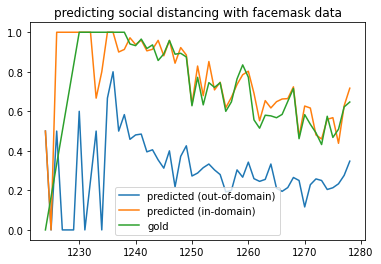

In [109]:
plot_data_predicted_fd = convert(data_predicted_fd)
plot_data_predicted_dd = convert(data_predicted_dd)
plot_data_gold = convert(data_gold)

x_gold = [x[0] for x in plot_data_gold]
y_gold = [x[1] for x in plot_data_gold]
x_fd = [x[0] for x in plot_data_predicted_fd]
y_fd = [x[1] for x in plot_data_predicted_fd]
x_dd = [x[0] for x in plot_data_predicted_dd]
y_dd = [x[1] for x in plot_data_predicted_dd]
plt.plot(x_fd, y_fd, label="predicted (out-of-domain)")
plt.plot(x_dd, y_dd, label="predicted (in-domain)")
plt.plot(x_gold, y_gold, label="gold")
plt.legend()
plt.title("predicting social distancing with facemask data")
plt.savefig("facemask-to-distancing.png")
plt.show()

### Inflate predictions (old)

In [110]:
def get_freqs(label_list):
    freqs = {}
    for label in label_list:
        if label in freqs:
            freqs[label] += 1
        else:
            freqs[label] = 1
    for label in freqs:
        freqs[label] /= len(label_list)
    return(freqs)

In [111]:
def inflate(predictionLabelsTestIn, source_label, target_label, factor):
    predictionLabelsTestOut = list(predictionLabelsTestIn)
    counter = 0
    for fold in predictionLabelsTestOut:
        for i in range(0, len(fold[0])):
            if fold[0][i][0] == target_label:
                for j in range(0, len(fold[0][i])):
                    if fold[0][i][j] == source_label:
                        break
                if fold[0][i][j] != source_label:
                    sys.exit("cannot happen")
                if fold[1][i][j]*factor > fold[1][i][0]:
                    fold[0][i][0], fold[0][i][j] = fold[0][i][j], fold[0][i][0]
    return(predictionLabelsTestOut)

In [112]:
def inflate_plus(predictionLabelsTestIn, source_label, target_label, factor):
    predictionLabelsTestOut = list(predictionLabelsTestIn)
    counter = 0
    for fold in predictionLabelsTestOut:
        for i in range(0, len(fold[0])):
            if fold[0][i][0] == target_label:
                for j in range(0, len(fold[0][i])):
                    if fold[0][i][j] == source_label:
                        break
                if fold[0][i][j] != source_label:
                    sys.exit("cannot happen")
                if fold[1][i][j]+factor > fold[1][i][0]:
                    fold[0][i][0], fold[0][i][j] = fold[0][i][j], fold[0][i][0]
    return(predictionLabelsTestOut)

In [113]:
freqs = get_freqs(gold)
print(freqs)
print(freqs['__label__REJECTS']/freqs['__label__SUPPORTS'])

{'__label__REJECTS': 0.19822020589774908, '__label__SUPPORTS': 0.5632524864770546, '__label__IRRELEVANT': 0.2385273076251963}
0.35192069392812886


In [114]:
FACTOR = 0.9967

predictionLabelsTestFDinflated = list(predictionLabelsTestFD)
freqs = get_freqs([y[0] for x in inflate_plus(predictionLabelsTestFDinflated, '__label__SUPPORTS', '__label__REJECTS', FACTOR) for y in x[0]])
print(freqs)
print(freqs['__label__REJECTS']/freqs['__label__SUPPORTS'])

{'__label__IRRELEVANT': 0.5379514918862328, '__label__SUPPORTS': 0.34252311987436745, '__label__REJECTS': 0.11952538823939976}
0.34895568008150796


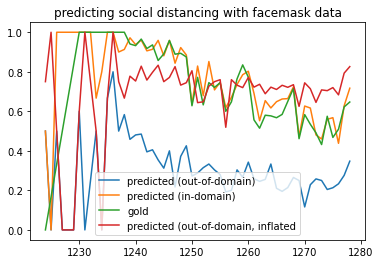

In [115]:
data_predicted_fd_inflated = make_data_predicted(predictionLabelsTestFDinflated, tweet_ids_distance)
plot_data_predicted_fd_inflated = convert(data_predicted_fd_inflated)

x_gold = [x[0] for x in plot_data_gold]
y_gold = [x[1] for x in plot_data_gold]
x_fd = [x[0] for x in plot_data_predicted_fd]
y_fd = [x[1] for x in plot_data_predicted_fd]
x_dd = [x[0] for x in plot_data_predicted_dd]
y_dd = [x[1] for x in plot_data_predicted_dd]
x_fd_inflated = [x[0] for x in plot_data_predicted_fd_inflated]
y_fd_inflated = [x[1] for x in plot_data_predicted_fd_inflated]
plt.plot(x_fd, y_fd, label="predicted (out-of-domain)")
plt.plot(x_dd, y_dd, label="predicted (in-domain)")
plt.plot(x_gold, y_gold, label="gold")
plt.plot(x_fd_inflated, y_fd_inflated, label="predicted (out-of-domain, inflated")
plt.legend()
plt.title("predicting social distancing with facemask data")
plt.savefig("facemask-to-distancing.png")
plt.show()

### Numerical analysis of predictions (old)

In [116]:
plot_data_predicted_fd_dict = { x[0]:x[1] for x in plot_data_predicted_fd }
plot_data_predicted_dd_dict = { x[0]:x[1] for x in plot_data_predicted_dd }
plot_data_gold_dict = { x[0]:x[1] for x in plot_data_gold }
plot_data_predicted_fd_inflated_dict = { x[0]:x[1] for x in plot_data_predicted_fd_inflated }

In [117]:
def get_common_key_values(dict1, dict2):
    values1 = []
    values2 = []
    for key in sorted(dict1.keys()):
        if key in dict2:
            values1.append(dict1[key])
            values2.append(dict2[key])
    return(values1, values2)

In [118]:
values_dd, values_gold_dd = get_common_key_values(plot_data_predicted_dd_dict, plot_data_gold_dict)
print("Pearson r correlation gold vs in-domain:", round(scipy.stats.linregress(np.array(values_gold_dd), np.array(values_dd)).rvalue, 2))
values_fd, values_gold_fd = get_common_key_values(plot_data_predicted_fd_dict, plot_data_gold_dict)
print("Pearson r correlation gold vs out-of-domain:", round(scipy.stats.linregress(np.array(values_gold_fd), np.array(values_fd)).rvalue, 2))
values_fd_inflated, values_gold_fd_inflated = get_common_key_values(plot_data_predicted_fd_inflated_dict, plot_data_gold_dict)
print("Pearson r correlation gold vs out-of-domain (inflated):", round(scipy.stats.linregress(np.array(values_gold_fd), np.array(values_fd_inflated)).rvalue, 2))

Pearson r correlation gold vs in-domain: 0.88
Pearson r correlation gold vs out-of-domain: 0.47
Pearson r correlation gold vs out-of-domain (inflated): -0.06


In [119]:
def absolute_difference(list1, list2):
    absolute_difference = 0
    for i in range(0, len(list1)):
        absolute_difference += abs(list1[i]-list2[i])
    return(absolute_difference/len(list1))

In [120]:
print("absolute difference gold vs in-domain:", round(absolute_difference(values_gold_dd, values_dd), 2))
print("absolute difference gold vs out-of-domain:", round(absolute_difference(values_gold_fd, values_fd),2))
print("absolute difference gold vs out-of-domain (inflated):", round(absolute_difference(values_gold_fd_inflated, values_fd_inflated),2)) 

absolute difference gold vs in-domain: 0.06
absolute difference gold vs out-of-domain: 0.42
absolute difference gold vs out-of-domain (inflated): 0.18


## Predicting facemasks with social distancing data (old)

In [121]:
if False:
    predictionCountsValidationDF,predictionLabelsValidationDF,predictionCountsTestDF,predictionLabelsTestDF = \
        runFasttext(fasttext_data_list_distance, fasttext_data_list_facemask, squealFlag=False, dim=300)

In [122]:
if False:
    predictionCountsValidationDFT,predictionLabelsValidationDFT,predictionCountsTestDFT,predictionLabelsTestDFT = \
        runFasttext(fasttext_data_list_distance, fasttext_data_list_facemask, squealFlag=False, dim=300, pretrainedVectors="twiqs-model-2020.vec")

In [123]:
if False:
    store_fasttext_data(predictionLabelsTestDFT, "predictionLabelsTestDFT.pickle")

In [124]:
predictionLabelsTestDF = read_fasttext_data("predictionLabelsTestDF.pickle")
predictionLabelsTestFF = read_fasttext_data("predictionLabelsTestFF.pickle")

In [125]:
time_factor = 5
data_predicted_df = make_data_predicted(predictionLabelsTestDF, tweet_ids_facemask, time_factor=time_factor)
data_predicted_ff = make_data_predicted(predictionLabelsTestFF, tweet_ids_facemask, time_factor=time_factor)

In [126]:
gold = []
for tweet in fasttext_data_list_facemask:
    gold.append(tweet.split()[0])

data_gold = {}
for i in range(0, len(tweet_ids_facemask)):
    summary = str(tweet_ids_facemask[i])[0:time_factor]
    if summary not in data_gold:
        data_gold[summary] = []
    data_gold[summary].append(gold[i])

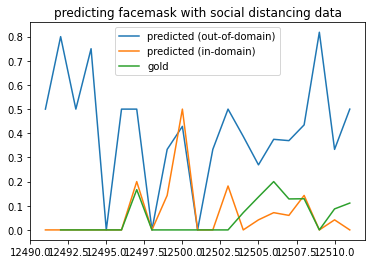

In [127]:
plot_data_predicted_df = convert(data_predicted_df)
plot_data_predicted_ff = convert(data_predicted_ff)
plot_data_gold = convert(data_gold)

x_gold = [x[0] for x in plot_data_gold]
y_gold = [x[1] for x in plot_data_gold]
x_df = [x[0] for x in plot_data_predicted_df]
y_df = [x[1] for x in plot_data_predicted_df]
x_ff = [x[0] for x in plot_data_predicted_ff]
y_ff = [x[1] for x in plot_data_predicted_ff]
plt.plot(x_df, y_df, label="predicted (out-of-domain)")
plt.plot(x_ff, y_ff, label="predicted (in-domain)")
plt.plot(x_gold, y_gold, label="gold")
plt.legend()
plt.title("predicting facemask with social distancing data")
plt.savefig("distancing-to-facemask.png")
plt.show()

### Inflate predictions (old)

In [128]:
freqs = get_freqs(gold)
print(freqs)
print(freqs['__label__REJECTS']/freqs['__label__SUPPORTS'])

{'__label__IRRELEVANT': 0.4809688581314879, '__label__REJECTS': 0.46366782006920415, '__label__SUPPORTS': 0.05536332179930796}
8.375


In [129]:
FACTOR = 0.9893

predictionLabelsTestDFinflated = list(predictionLabelsTestDF)
freqs = get_freqs([y[0] for x in inflate_plus(predictionLabelsTestDFinflated, '__label__REJECTS', '__label__SUPPORTS', FACTOR) for y in x[0]])
print(freqs)
print(freqs['__label__REJECTS']/freqs['__label__SUPPORTS'])

{'__label__IRRELEVANT': 0.27760968229954613, '__label__REJECTS': 0.518910741301059, '__label__SUPPORTS': 0.20347957639939485}
2.550185873605948


In [130]:
data_predicted_df_inflated = make_data_predicted(inflate(predictionLabelsTestDFinflated, '__label__REJECTS', '__label__SUPPORTS', FACTOR), tweet_ids_facemask, time_factor=1)

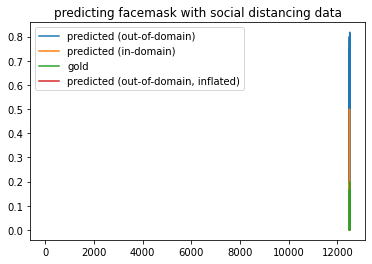

In [131]:
plot_data_predicted_df = convert(data_predicted_df)
plot_data_predicted_ff = convert(data_predicted_ff)
plot_data_predicted_df_inflated = convert(data_predicted_df_inflated)
plot_data_gold = convert(data_gold)

x_gold = [x[0] for x in plot_data_gold]
y_gold = [x[1] for x in plot_data_gold]
x_df = [x[0] for x in plot_data_predicted_df]
y_df = [x[1] for x in plot_data_predicted_df]
x_ff = [x[0] for x in plot_data_predicted_ff]
y_ff = [x[1] for x in plot_data_predicted_ff]
x_df_inflated = [x[0] for x in plot_data_predicted_df_inflated]
y_df_inflated = [x[1] for x in plot_data_predicted_df_inflated]
plt.plot(x_df, y_df, label="predicted (out-of-domain)")
plt.plot(x_ff, y_ff, label="predicted (in-domain)")
plt.plot(x_gold, y_gold, label="gold")
plt.plot(x_df_inflated, y_df_inflated, label="predicted (out-of-domain, inflated)")
plt.legend()
plt.title("predicting facemask with social distancing data")
plt.savefig("distancing-to-facemask.png")
plt.show()

### Numerical analysis of predictions (old)

In [132]:
plot_data_predicted_df_dict = { x[0]:x[1] for x in plot_data_predicted_df }
plot_data_predicted_ff_dict = { x[0]:x[1] for x in plot_data_predicted_ff }
plot_data_predicted_df_inflated_dict = { x[0]:x[1] for x in plot_data_predicted_df_inflated }
plot_data_gold_dict = { x[0]:x[1] for x in plot_data_gold }

In [133]:
values_ff, values_gold_ff = get_common_key_values(plot_data_predicted_ff_dict, plot_data_gold_dict)
print("Pearson r correlation gold vs in-domain:", round(scipy.stats.linregress(np.array(values_gold_ff), np.array(values_ff)).rvalue, 2))
values_df, values_gold_df = get_common_key_values(plot_data_predicted_df_dict, plot_data_gold_dict)
print("Pearson r correlation gold vs out-of-domain:", round(scipy.stats.linregress(np.array(values_gold_df), np.array(values_df)).rvalue, 2))
values_df_inflated, values_gold_df_inflated = get_common_key_values(plot_data_predicted_df_inflated_dict, plot_data_gold_dict)
print("Pearson r correlation gold vs out-of-domain (inflated):", round(scipy.stats.linregress(np.array(values_gold_df_inflated), np.array(values_df_inflated)).rvalue, 2))

Pearson r correlation gold vs in-domain: 0.05
Pearson r correlation gold vs out-of-domain: -0.11


ValueError: Inputs must not be empty.

In [44]:
print("absolute difference gold vs in-domain:", round(absolute_difference(values_gold_ff, values_ff), 2))
print("absolute difference gold vs out-of-domain:", round(absolute_difference(values_gold_df, values_df),2)) 
print("absolute difference gold vs out-of-domain (inflated):", round(absolute_difference(values_gold_df_inflated, values_df_inflated),2)) 

absolute difference gold vs in-domain: 0.07
absolute difference gold vs out-of-domain: 0.37


ZeroDivisionError: division by zero

### Predicting testing data with distance data (old)

In [134]:
if False:
    predictionCountsValidationDT, predictionLabelsValidationDT, predictionCountsTestDT, predictionLabelsTestDT = \
        runFasttext(fasttext_data_list_distance, fasttext_data_list_testing, squealFlag=False, dim=300)

In [135]:
if False:
    predictionCountsValidationDT, predictionLabelsValidationDT, predictionCountsTestDT, predictionLabelsTestDT = \
        runFasttext(fasttext_data_list_distance, 
                    fasttext_data_list_testing, 
                    squealFlag=False, 
                    dim=300, 
                    pretrainedVectors="twiqs-model-2020.vec")

In [136]:
if False:
    store_fasttext_data(predictionLabelsTestDT, "predictionLabelsTestDT.pickle")

In [137]:
predictionLabelsTestDT = read_fasttext_data("predictionLabelsTestDT.pickle")
predictionLabelsTestTT = read_fasttext_data("predictionLabelsTestTT.pickle")

In [138]:
time_factor = 3
data_predicted_dt = make_data_predicted(predictionLabelsTestDT, tweet_ids_testing, time_factor=time_factor)
data_predicted_tt = make_data_predicted(predictionLabelsTestTT, tweet_ids_testing, time_factor=time_factor)

In [139]:
gold = []
for tweet in fasttext_data_list_testing:
    gold.append(tweet.split()[0])

data_gold = {}
for i in range(0, len(tweet_ids_testing)):
    summary = str(tweet_ids_testing[i])[0:time_factor]
    if summary not in data_gold:
        data_gold[summary] = []
    data_gold[summary].append(gold[i])

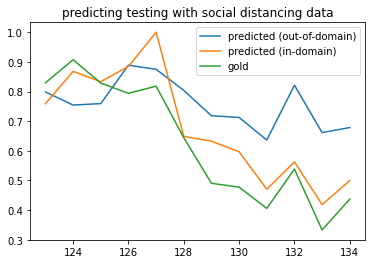

In [140]:
plot_data_predicted_dt = convert(data_predicted_dt)
plot_data_predicted_tt = convert(data_predicted_tt)
plot_data_gold = convert(data_gold)

x_gold = [x[0] for x in plot_data_gold]
y_gold = [x[1] for x in plot_data_gold]
x_df = [x[0] for x in plot_data_predicted_dt]
y_df = [x[1] for x in plot_data_predicted_dt]
x_ff = [x[0] for x in plot_data_predicted_tt]
y_ff = [x[1] for x in plot_data_predicted_tt]
plt.plot(x_df, y_df, label="predicted (out-of-domain)")
plt.plot(x_ff, y_ff, label="predicted (in-domain)")
plt.plot(x_gold, y_gold, label="gold")
plt.legend()
plt.title("predicting testing with social distancing data")
plt.savefig("distancing-to-testing.png")
plt.show()

## 3. Use extra data in training (ALL)

In [167]:
def runFasttextPlus(fasttextData1,
                    fasttextData2,
                    dim=DIM,
                    epoch=EPOCH,
                    lr=LR,
                    n=N,
                    squealFlag=True,
                    maxTrain=None,
                    pretrainedVectors=None,
                    extraFasttextData=None):
    print(f"data size 1={len(fasttextData1)}, data size 2={len(fasttextData2)}, dim={dim}, epoch={epoch}, lr={lr}, pretrainedVectors={pretrainedVectors}")
    predictionCountsTest = []
    predictionLabelsTest = []
    predictionCountsValidation = []
    predictionLabelsValidation = []
    for fold in range(0,n):
        if squealFlag:
            clear_output(wait=True)
            print("starting fold",fold)
        testStart1 = round(fold*len(fasttextData1)/n)
        testEnd1 = round((fold+1)*len(fasttextData1)/n)
        testStart2 = round(fold*len(fasttextData2)/n)
        testEnd2 = round((fold+1)*len(fasttextData2)/n)
        if fold < n-1: nextFold = fold+1
        else: nextFold = 0
        validationStart1 = round(nextFold*len(fasttextData1)/n)
        validationEnd1 = round((nextFold+1)*len(fasttextData1)/n)
        validationStart2 = round(nextFold*len(fasttextData2)/n)
        validationEnd2 = round((nextFold+1)*len(fasttextData2)/n)
        trainFile = open(TRAIN,"w")
        testFile = open(TEST,"w")
        validationFile = open(VALIDATION,"w")
        trainData = []
        validationData = []
        testData = []
        for i in range(0,len(fasttextData1)):
            data = fasttextData1[i]
            if i >= testStart1 and i < testEnd1: 
                pass
            elif i >= validationStart1 and i < validationEnd1: 
                pass
            else: 
                print(data,file=trainFile)
                trainData.append(data)
        for i in range(0,len(fasttextData2)):
            data = fasttextData2[i]
            if i >= testStart2 and i < testEnd2: 
                print(data,file=testFile)
                testData.append(data)
            elif i >= validationStart2 and i < validationEnd2: 
                print(data,file=validationFile)
                validationData.append(data)
        if extraFasttextData != None:
            for i in range(0,len(extraFasttextData)):
                data = extraFasttextData[i]
                print(data,file=trainFile)
                trainData.append(data)
        testFile.close()
        trainFile.close()
        validationFile.close()
        if not maxTrain == None and maxTrain < len(trainData):
            trainData = ranSelect(trainData,maxTrain)
            trainFile = open(TRAIN,"w")
            for i in range(0,len(trainData)):
                print(trainData[i],file=trainFile)
            trainFile.close()
        if pretrainedVectors == None:
            model = fasttext.train_supervised(TRAIN, dim=dim, epoch=epoch, lr=lr)
        else:
            model = fasttext.train_supervised(TRAIN, dim=dim, epoch=epoch, lr=lr, pretrainedVectors=pretrainedVectors)
        predictionCountsValidation.append([*model.test(VALIDATION)])
        predictionLabelsValidation.append(model.predict(validationData, k=3))
        predictionCountsTest.append([*model.test(TEST)])
        predictionLabelsTest.append(model.predict(testData, k=3))
        print(fold, end=" ")
        evaluate([[*model.test(TEST)]], [model.predict(testData)], fasttextData2[testStart2:testEnd2])
        os.unlink(TRAIN)
        os.unlink(TEST)
        os.unlink(VALIDATION)
    print("", end=" ")
    evaluate(predictionCountsTest, predictionLabelsTest, fasttextData2, printMatrix=True)
    if squealFlag:
        clear_output(wait=True)
        print("finished")
    return(predictionCountsValidation,predictionLabelsValidation,predictionCountsTest,predictionLabelsTest)

In [440]:
predictionCountsValidationETT, predictionLabelsValidationETT, predictionCountsTestETT, predictionLabelsTestETT = \
    runFasttextPlus(fasttext_data_list_testing, 
                    fasttext_data_list_testing, 
                    squealFlag=False, 
                    pretrainedVectors="twiqs-model-2020-exf.vec",
                    extraFasttextData=fasttext_data_list_distance)

data size 1=1181, data size 2=1181, dim=300, epoch=200, lr=0.2, pretrainedVectors=twiqs-model-2020-exf.vec
0 cases: 118; precision: 0.449; recall: 0.449; fraction: 3.044
1 cases: 118; precision: 0.424; recall: 0.424; fraction: 1.130
2 cases: 118; precision: 0.525; recall: 0.525; fraction: 2.683
3 cases: 118; precision: 0.517; recall: 0.517; fraction: 1.083
4 cases: 118; precision: 0.576; recall: 0.576; fraction: 0.897
5 cases: 119; precision: 0.538; recall: 0.538; fraction: 0.316
6 cases: 118; precision: 0.602; recall: 0.602; fraction: 0.500
7 cases: 118; precision: 0.551; recall: 0.551; fraction: 0.668
8 cases: 118; precision: 0.602; recall: 0.602; fraction: 0.857
9 cases: 118; precision: 0.627; recall: 0.627; fraction: 0.889
 col_0                __label__IRRELEVANT  __label__REJECTS  __label__SUPPORTS
row_0                                                                        
__label__IRRELEVANT                  376                77                178
__label__REJECTS            

In [441]:
store_fasttext_data(predictionLabelsTestETT, f"predictionLabelsTestETT-{DIM}-{EPOCH}-{LR}.pickle")

In [471]:
predictionCountsValidationEFT, predictionLabelsValidationEFT, predictionCountsTestEFT, predictionLabelsTestEFT = \
    runFasttextPlus(fasttext_data_list_facemask, 
                    fasttext_data_list_facemask, 
                    squealFlag=False, 
                    pretrainedVectors="twiqs-model-2020-exf.vec",
                    extraFasttextData=fasttext_data_list_distance)

data size 1=1011, data size 2=1011, dim=300, epoch=200, lr=0.2, pretrainedVectors=twiqs-model-2020-exf.vec
0 cases: 101; precision: 0.574; recall: 0.574; fraction: 6.667
1 cases: 101; precision: 0.525; recall: 0.525; fraction: 0.879
2 cases: 101; precision: 0.614; recall: 0.614; fraction: 0.649
3 cases: 101; precision: 0.465; recall: 0.465; fraction: 2.122
4 cases: 102; precision: 0.510; recall: 0.510; fraction: 3.028
5 cases: 101; precision: 0.564; recall: 0.564; fraction: 0.875
6 cases: 101; precision: 0.624; recall: 0.624; fraction: 0.383
7 cases: 101; precision: 0.485; recall: 0.485; fraction: 0.393
8 cases: 101; precision: 0.545; recall: 0.545; fraction: 0.421
9 cases: 101; precision: 0.525; recall: 0.525; fraction: 0.263
 col_0                __label__IRRELEVANT  __label__REJECTS  __label__SUPPORTS
row_0                                                                        
__label__IRRELEVANT                  348                78                132
__label__REJECTS            

In [472]:
store_fasttext_data(predictionLabelsTestEFT, f"predictionLabelsTestEFT-{DIM}-{EPOCH}-{LR}.pickle")

In [473]:
predictionCountsValidationEVT, predictionLabelsValidationEVT, predictionCountsTestEVT, predictionLabelsTestEVT = \
    runFasttextPlus(fasttext_data_list_vaccination, 
                    fasttext_data_list_vaccination, 
                    squealFlag=False, 
                    pretrainedVectors="twiqs-model-2020-exf.vec",
                    extraFasttextData=fasttext_data_list_distance)

data size 1=1007, data size 2=1007, dim=300, epoch=200, lr=0.2, pretrainedVectors=twiqs-model-2020-exf.vec
0 cases: 101; precision: 0.624; recall: 0.624; fraction: 1.138
1 cases: 100; precision: 0.690; recall: 0.690; fraction: 0.406
2 cases: 101; precision: 0.604; recall: 0.604; fraction: 0.296
3 cases: 101; precision: 0.594; recall: 0.594; fraction: 0.181
4 cases: 101; precision: 0.406; recall: 0.406; fraction: 0.416
5 cases: 100; precision: 0.580; recall: 0.580; fraction: 0.165
6 cases: 101; precision: 0.624; recall: 0.624; fraction: 0.478
7 cases: 101; precision: 0.574; recall: 0.574; fraction: 0.671
8 cases: 100; precision: 0.540; recall: 0.540; fraction: 0.903
9 cases: 101; precision: 0.485; recall: 0.485; fraction: 1.300
 col_0                __label__IRRELEVANT  __label__REJECTS  __label__SUPPORTS
row_0                                                                        
__label__IRRELEVANT                  428               111                 99
__label__REJECTS            

In [474]:
store_fasttext_data(predictionLabelsTestEVT, f"predictionLabelsTestEVT-{DIM}-{EPOCH}-{LR}.pickle")

## 4. Relevance experiments

For the Relevance Only (5. RLVONLY) experiment, we need relevance preprocessing. This is a easier (binary) task which is handled here. 

In [162]:
def make_binary_fasttext_data(fasttext_data_list_in):
    fasttext_data_list_out = []
    for text in fasttext_data_list_in:
        text = re.sub(r'__label__SUPPORTS ', r'__label__RELEVANT ', text)
        text = re.sub(r'__label__REJECTS ', r'__label__RELEVANT ', text)
        fasttext_data_list_out.append(text)
    return fasttext_data_list_out

In [165]:
fasttext_data_list_facemask_binary = make_binary_fasttext_data(fasttext_data_list_facemask)

In [172]:
predictionCountsValidationFFB, predictionLabelsValidationFFB, predictionCountsTestFFB, predictionLabelsTestFFB = \
    runFasttext(fasttext_data_list_facemask_binary, fasttext_data_list_facemask_binary, squealFlag=False, pretrainedVectors="twiqs-model-2020.vec")

data size 1=1011, data size 2=1011, dim=300, epoch=200, lr=0.2, pretrainedVectors=twiqs-model-2020.vec
0 cases: 101; precision: 0.663; recall: 0.663; fraction: 0.000
1 cases: 101; precision: 0.713; recall: 0.713; fraction: 0.000
2 cases: 101; precision: 0.703; recall: 0.703; fraction: 0.000
3 cases: 101; precision: 0.594; recall: 0.594; fraction: 0.000
4 cases: 102; precision: 0.686; recall: 0.686; fraction: 0.000
5 cases: 101; precision: 0.584; recall: 0.584; fraction: 0.000
6 cases: 101; precision: 0.634; recall: 0.634; fraction: 0.000
7 cases: 101; precision: 0.554; recall: 0.554; fraction: 0.000
8 cases: 101; precision: 0.604; recall: 0.604; fraction: 0.000
9 cases: 101; precision: 0.604; recall: 0.604; fraction: 0.000
 col_0                __label__IRRELEVANT  __label__RELEVANT
row_0                                                      
__label__IRRELEVANT                  380                178
__label__RELEVANT                    192                261
cases: 1011; precision: 0.

In [173]:
store_fasttext_data(predictionLabelsTestFFB, f"predictionLabelsTestFFB-{DIM}-{EPOCH}-{LR}.pickle")

In [174]:
fasttext_data_list_testing_binary = make_binary_fasttext_data(fasttext_data_list_testing)

In [175]:
predictionCountsValidationTTB, predictionLabelsValidationTTB, predictionCountsTestTTB, predictionLabelsTestTTB = \
    runFasttext(fasttext_data_list_testing_binary, fasttext_data_list_testing_binary, squealFlag=False, pretrainedVectors="twiqs-model-2020.vec")

data size 1=1181, data size 2=1181, dim=300, epoch=200, lr=0.2, pretrainedVectors=twiqs-model-2020.vec
0 cases: 118; precision: 0.576; recall: 0.576; fraction: 0.000
1 cases: 118; precision: 0.619; recall: 0.619; fraction: 0.000
2 cases: 118; precision: 0.686; recall: 0.686; fraction: 0.000
3 cases: 118; precision: 0.593; recall: 0.593; fraction: 0.000
4 cases: 118; precision: 0.627; recall: 0.627; fraction: 0.000
5 cases: 119; precision: 0.639; recall: 0.639; fraction: 0.000
6 cases: 118; precision: 0.619; recall: 0.619; fraction: 0.000
7 cases: 118; precision: 0.754; recall: 0.754; fraction: 0.000
8 cases: 118; precision: 0.576; recall: 0.576; fraction: 0.000
9 cases: 118; precision: 0.610; recall: 0.610; fraction: 0.000
 col_0                __label__IRRELEVANT  __label__RELEVANT
row_0                                                      
__label__IRRELEVANT                  428                203
__label__RELEVANT                    234                316
cases: 1181; precision: 0.

In [176]:
store_fasttext_data(predictionLabelsTestTTB, f"predictionLabelsTestTTB-{DIM}-{EPOCH}-{LR}.pickle")

In [177]:
fasttext_data_list_vaccination_binary = make_binary_fasttext_data(fasttext_data_list_vaccination)

In [178]:
predictionCountsValidationVVB, predictionLabelsValidationVVB, predictionCountsTestVVB, predictionLabelsTestVVB = \
    runFasttext(fasttext_data_list_vaccination_binary, fasttext_data_list_vaccination_binary, squealFlag=False, pretrainedVectors="twiqs-model-2020.vec")

data size 1=1007, data size 2=1007, dim=300, epoch=200, lr=0.2, pretrainedVectors=twiqs-model-2020.vec
0 cases: 101; precision: 0.663; recall: 0.663; fraction: 0.000
1 cases: 100; precision: 0.680; recall: 0.680; fraction: 0.000
2 cases: 101; precision: 0.713; recall: 0.713; fraction: 0.000
3 cases: 101; precision: 0.673; recall: 0.673; fraction: 0.000
4 cases: 101; precision: 0.574; recall: 0.574; fraction: 0.000
5 cases: 100; precision: 0.570; recall: 0.570; fraction: 0.000
6 cases: 101; precision: 0.584; recall: 0.584; fraction: 0.000
7 cases: 101; precision: 0.515; recall: 0.515; fraction: 0.000
8 cases: 100; precision: 0.580; recall: 0.580; fraction: 0.000
9 cases: 101; precision: 0.594; recall: 0.594; fraction: 0.000
 col_0                __label__IRRELEVANT  __label__RELEVANT
row_0                                                      
__label__IRRELEVANT                  466                172
__label__RELEVANT                    216                153
cases: 1007; precision: 0.

In [179]:
store_fasttext_data(predictionLabelsTestVVB, f"predictionLabelsTestVVB-{DIM}-{EPOCH}-{LR}.pickle")

## 5. Use relevant data only (RLVONLY)

In [151]:
def remove_irrelevant_annotated_data(fasttext_data_list):
    return [annotated_text for annotated_text in fasttext_data_list if not re.search(r'^__label__IRRELEVANT ', annotated_text)]


def remove_irrelevant_predicted_data(predictionLabelsTest, fasttext_data_list):
    prediction_labels = get_prediction_labels_list(predictionLabelsTest)
    assert len(prediction_labels) == len(fasttext_data_list), "remove_irrelevant_data: lists have different lengths"
    fasttext_data_list_selected = []
    for i in range(0, len(prediction_labels)):
        if prediction_labels[i] != "__label__IRRELEVANT":
            fasttext_data_list_selected.append(fasttext_data_list[i])
    return fasttext_data_list_selected


def restore_irrelevant_predicted_data(prediction_labels_in, prediction_labels_relevant):
    prediction_labels = list(prediction_labels_in)
    prediction_labels_relevant_index = 0
    for i in range(0, len(prediction_labels)):
        if prediction_labels[i] != "__label__IRRELEVANT":
            prediction_labels[i] = prediction_labels_relevant[prediction_labels_relevant_index]
            prediction_labels_relevant_index += 1
    assert prediction_labels_relevant_index == len(prediction_labels_relevant), \
           f"restore_irrelevant_predicted_data: length mismatch: {prediction_labels_relevant_index} {len(prediction_labels_relevant)}"
    return prediction_labels


def save_fasttext_data(fasttext_data_list, file_name):
    out_file = open(file_name, "w")
    for line in fasttext_data_list:
        print(line, file=out_file)
    out_file.close()

In [83]:
def make_relevant_model(fasttext_data_list):
    fasttext_data_list_selected = remove_irrelevant_annotated_data(fasttext_data_list)
    print(f"building relevant model from: data_size={len(fasttext_data_list_selected)}, dim={DIM}, epoch={EPOCH}, lr={LR}")
    tmp_file_name = str(uuid.uuid1())
    save_fasttext_data(fasttext_data_list_distance_selected, tmp_file_name)
    model_relevant = fasttext.train_supervised(tmp_file_name, dim=DIM, epoch=EPOCH, lr=LR, pretrainedVectors="twiqs-model-2020.vec")
    os.remove(tmp_file_name)
    return model_relevant

In [66]:
model_relevant = make_relevant_model(fasttext_data_list_distance)

building model from: data_size=4364, dim=300, epoch=200, lr=0.2


In [447]:
def run_relevant_experiment(model_relevant, result_file_name, fasttext_data_list):
    predictionLabelsTest = read_fasttext_data(result_file_name)
    fasttext_data_list_selected = remove_irrelevant_data(predictionLabelsTest, fasttext_data_list)
    prediction_labels_relevant = model_relevant.predict(fasttext_data_list_selected)
    prediction_labels_relevant_complete = restore_irrelevant_predicted_data(get_prediction_labels_list(predictionLabelsTest), get_prediction_labels_list([prediction_labels_relevant]))
    accuracy = compute_accuracy(prediction_labels_relevant_complete, fasttext_data_list)
    accuracy_phase_1 = compute_accuracy(get_prediction_labels_list(predictionLabelsTest), fasttext_data_list)
    gold_labels_selected = [annotated_text.split(" ")[0] for annotated_text in fasttext_data_list_selected]
    accuracy_phase_1_plus_gold = compute_accuracy(restore_irrelevant_predicted_data(get_prediction_labels_list(predictionLabelsTest), gold_labels_selected), fasttext_data_list) 
    print(f"accuracy (phase 1): {accuracy_phase_1}, accuracy (phase 1 plus gold): {accuracy_phase_1_plus_gold}, accuracy (phase 2): {accuracy}")
    
    
def run_relevant_experiment_binary(model_relevant, result_file_name, fasttext_data_list):
    predictionLabelsTest = read_fasttext_data(result_file_name)
    fasttext_data_list_selected = remove_irrelevant_data(predictionLabelsTest, fasttext_data_list)
    prediction_labels_relevant = model_relevant.predict(fasttext_data_list_selected)
    prediction_labels_relevant_complete = restore_irrelevant_predicted_data(get_prediction_labels_list(predictionLabelsTest), get_prediction_labels_list([prediction_labels_relevant]))
    accuracy = compute_accuracy(prediction_labels_relevant_complete, fasttext_data_list)
    accuracy_phase_1 = compute_accuracy(get_prediction_labels_list(predictionLabelsTest), make_binary_fasttext_data(fasttext_data_list))
    gold_labels_selected = [annotated_text.split(" ")[0] for annotated_text in fasttext_data_list_selected]
    accuracy_phase_1_plus_gold = compute_accuracy(restore_irrelevant_predicted_data(get_prediction_labels_list(predictionLabelsTest), gold_labels_selected), fasttext_data_list) 
    print(f"accuracy (phase 1): {accuracy_phase_1}, accuracy (phase 1 plus gold): {accuracy_phase_1_plus_gold}, accuracy (phase 2): {accuracy}")
    
    
def run_relevant_experiment_all(result_file_name, fasttext_data_list, fasttext_data_list_extra):
    predictionLabelsTest = read_fasttext_data(result_file_name)
    fasttext_data_list_selected = remove_irrelevant_data(predictionLabelsTest, fasttext_data_list)
    fasttext_data_list_extra_selected = remove_irrelevant_annotated_data(fasttext_data_list_extra)
    predictionCountsValidationRun, predictionLabelsValidationRun, predictionCountsTestRun, predictionLabelsTestRun = \
        runFasttextPlus(fasttext_data_list_selected, 
                        fasttext_data_list_selected, 
                        squealFlag=False, 
                        pretrainedVectors="twiqs-model-2020-exf.vec",
                        extraFasttextData=fasttext_data_list_extra_selected)
    prediction_labels_relevant_complete = restore_irrelevant_predicted_data(get_prediction_labels_list(predictionLabelsTest), get_prediction_labels_list(predictionLabelsTestRun))
    accuracy = compute_accuracy(prediction_labels_relevant_complete, fasttext_data_list)
    store_fasttext_data(prediction_labels_relevant_complete, f"{result_file_name}.RLV-{DIM}-{EPOCH}-{LR}.pickle")
    accuracy_phase_1 = compute_accuracy(get_prediction_labels_list(predictionLabelsTest), fasttext_data_list)
    gold_labels_selected = [annotated_text.split(" ")[0] for annotated_text in fasttext_data_list_selected]
    accuracy_phase_1_plus_gold = compute_accuracy(restore_irrelevant_predicted_data(get_prediction_labels_list(predictionLabelsTest), gold_labels_selected), fasttext_data_list) 
    print(f"accuracy (phase 1): {accuracy_phase_1}, accuracy (phase 1 plus gold): {accuracy_phase_1_plus_gold}, accuracy (phase 2): {accuracy}")

In [189]:
run_relevant_experiment(model_relevant, f"predictionLabelsTestFFT-{DIM}-{EPOCH}-{LR}.pickle", fasttext_data_list_facemask)

accuracy (phase 1): 0.58, accuracy (phase 1 plus gold): 0.776, accuracy (phase 2): 0.55


In [184]:
run_relevant_experiment(model_relevant, f"predictionLabelsTestFFB-{DIM}-{EPOCH}-{LR}.pickle", fasttext_data_list_facemask)

accuracy (phase 1): 0.634, accuracy (phase 1 plus gold): 0.81, accuracy (phase 2): 0.525


In [475]:
run_relevant_experiment_all(f"predictionLabelsTestFFT-{DIM}-{EPOCH}-{LR}.pickle", fasttext_data_list_facemask, fasttext_data_list_distance)

data size 1=373, data size 2=373, dim=300, epoch=200, lr=0.2, pretrainedVectors=twiqs-model-2020-exf.vec
0 cases: 37; precision: 0.243; recall: 0.243; fraction: 2.347
1 cases: 38; precision: 0.395; recall: 0.395; fraction: 0.774
2 cases: 37; precision: 0.378; recall: 0.378; fraction: 1.067
3 cases: 37; precision: 0.432; recall: 0.432; fraction: 2.615
4 cases: 37; precision: 0.459; recall: 0.459; fraction: 2.196
5 cases: 38; precision: 0.553; recall: 0.553; fraction: 0.833
6 cases: 37; precision: 0.486; recall: 0.486; fraction: 0.312
7 cases: 37; precision: 0.432; recall: 0.432; fraction: 0.290
8 cases: 38; precision: 0.316; recall: 0.316; fraction: 0.360
9 cases: 37; precision: 0.486; recall: 0.486; fraction: 0.341
 col_0                __label__IRRELEVANT  __label__REJECTS  __label__SUPPORTS
row_0                                                                        
__label__IRRELEVANT                   23                51                 65
__label__REJECTS                      25

In [448]:
run_relevant_experiment(model_relevant, f"predictionLabelsTestTTT-{DIM}-{EPOCH}-{LR}.pickle", fasttext_data_list_testing)

accuracy (phase 1): 0.561, accuracy (phase 1 plus gold): 0.775, accuracy (phase 2): 0.547


In [185]:
run_relevant_experiment(model_relevant, f"predictionLabelsTestTTB-{DIM}-{EPOCH}-{LR}.pickle", fasttext_data_list_testing)

accuracy (phase 1): 0.63, accuracy (phase 1 plus gold): 0.802, accuracy (phase 2): 0.555


In [476]:
run_relevant_experiment_all(f"predictionLabelsTestTTT-{DIM}-{EPOCH}-{LR}.pickle", fasttext_data_list_testing, fasttext_data_list_distance)

data size 1=481, data size 2=481, dim=300, epoch=200, lr=0.2, pretrainedVectors=twiqs-model-2020-exf.vec
0 cases: 48; precision: 0.188; recall: 0.188; fraction: 2.286
1 cases: 48; precision: 0.438; recall: 0.438; fraction: 1.950
2 cases: 48; precision: 0.417; recall: 0.417; fraction: 3.619
3 cases: 48; precision: 0.500; recall: 0.500; fraction: 0.672
4 cases: 48; precision: 0.562; recall: 0.562; fraction: 0.812
5 cases: 49; precision: 0.592; recall: 0.592; fraction: 0.737
6 cases: 48; precision: 0.521; recall: 0.521; fraction: 0.727
7 cases: 48; precision: 0.688; recall: 0.688; fraction: 0.980
8 cases: 48; precision: 0.542; recall: 0.542; fraction: 0.821
9 cases: 48; precision: 0.562; recall: 0.562; fraction: 1.250
 col_0                __label__IRRELEVANT  __label__REJECTS  __label__SUPPORTS
row_0                                                                        
__label__IRRELEVANT                   65                49                 83
__label__REJECTS                      19

In [160]:
run_relevant_experiment(model_relevant, f"predictionLabelsTestVVT-{DIM}-{EPOCH}-{LR}.pickle", fasttext_data_list_vaccination)

accuracy (phase 1): 0.6, accuracy (phase 1 plus gold): 0.771, accuracy (phase 2): 0.576


In [187]:
run_relevant_experiment(model_relevant, f"predictionLabelsTestVVB-{DIM}-{EPOCH}-{LR}.pickle", fasttext_data_list_vaccination)

accuracy (phase 1): 0.615, accuracy (phase 1 plus gold): 0.786, accuracy (phase 2): 0.563


In [477]:
run_relevant_experiment_all(f"predictionLabelsTestVVT-{DIM}-{EPOCH}-{LR}.pickle", fasttext_data_list_vaccination, fasttext_data_list_distance)

data size 1=273, data size 2=273, dim=300, epoch=200, lr=0.2, pretrainedVectors=twiqs-model-2020-exf.vec
0 cases: 27; precision: 0.222; recall: 0.222; fraction: 2.438
1 cases: 28; precision: 0.179; recall: 0.179; fraction: 0.582
2 cases: 27; precision: 0.407; recall: 0.407; fraction: 0.306
3 cases: 27; precision: 0.370; recall: 0.370; fraction: 0.636
4 cases: 27; precision: 0.556; recall: 0.556; fraction: 0.306
5 cases: 28; precision: 0.464; recall: 0.464; fraction: 0.971
6 cases: 27; precision: 0.296; recall: 0.296; fraction: 0.000
7 cases: 27; precision: 0.259; recall: 0.259; fraction: 0.423
8 cases: 28; precision: 0.143; recall: 0.143; fraction: 0.389
9 cases: 27; precision: 0.370; recall: 0.370; fraction: 1.750
 col_0                __label__IRRELEVANT  __label__REJECTS  __label__SUPPORTS
row_0                                                                        
__label__IRRELEVANT                   31                64                 43
__label__REJECTS                      46

## 6. Daume Feature Space Separation

Schemes:
1. [x] without setting initial word vectors for new vector spaces
2. [ ] while also changing classes
3. [x] while setting initial word vectors for new vector spaces

In [449]:
def expand_features(fasttext_data_list_in, suffix):
    fasttext_data_list_out = []
    for text in fasttext_data_list_in:
        tokens_in = text.split()
        tokens_out = []
        for token in tokens_in[1:]:
            tokens_out.append(token + suffix)
        fasttext_data_list_out.append(" ".join(tokens_in + tokens_out))
    return fasttext_data_list_out


def run_relevant_experiment_expand_features(result_file_name, fasttext_data_list, fasttext_data_list_extra):
    predictionLabelsTest = read_fasttext_data(result_file_name)
    fasttext_data_list_selected = expand_features(remove_irrelevant_data(predictionLabelsTest, fasttext_data_list), "@1")
    fasttext_data_list_extra_selected = expand_features(remove_irrelevant_annotated_data(fasttext_data_list_extra), "@2")
    predictionCountsValidationRun, predictionLabelsValidationRun, predictionCountsTestRun, predictionLabelsTestRun = \
        runFasttextPlus(fasttext_data_list_selected, 
                        fasttext_data_list_selected, 
                        squealFlag=False, 
                        pretrainedVectors="twiqs-model-2020-exf.vec",
                        extraFasttextData=fasttext_data_list_extra_selected)
    prediction_labels_relevant_complete = restore_irrelevant_predicted_data(get_prediction_labels_list(predictionLabelsTest), get_prediction_labels_list(predictionLabelsTestRun))
    accuracy = compute_accuracy(prediction_labels_relevant_complete, fasttext_data_list)
    accuracy_phase_1 = compute_accuracy(get_prediction_labels_list(predictionLabelsTest), fasttext_data_list)
    gold_labels_selected = [annotated_text.split(" ")[0] for annotated_text in fasttext_data_list_selected]
    accuracy_phase_1_plus_gold = compute_accuracy(restore_irrelevant_predicted_data(get_prediction_labels_list(predictionLabelsTest), gold_labels_selected), fasttext_data_list) 
    print(f"accuracy (phase 1): {accuracy_phase_1}, accuracy (phase 1 plus gold): {accuracy_phase_1_plus_gold}, accuracy (phase 2): {accuracy}")

In [214]:
def expand_features(fasttext_data_list_in, suffix):
    fasttext_data_list_out = []
    for text in fasttext_data_list_in:
        tokens_in = text.split()
        tokens_out = []
        for token in tokens_in[1:]:
            tokens_out.append(token + suffix)
        fasttext_data_list_out.append(" ".join(tokens_in + tokens_out))
    return fasttext_data_list_out


def run_relevant_experiment_expand_features(result_file_name, fasttext_data_list, fasttext_data_list_extra):
    predictionLabelsTest = read_fasttext_data(result_file_name)
    fasttext_data_list_selected = expand_features(remove_irrelevant_data(predictionLabelsTest, fasttext_data_list), "@1")
    fasttext_data_list_extra_selected = expand_features(remove_irrelevant_annotated_data(fasttext_data_list_extra), "@2")
    predictionCountsValidationRun, predictionLabelsValidationRun, predictionCountsTestRun, predictionLabelsTestRun = \
        runFasttextPlus(fasttext_data_list_selected, 
                        fasttext_data_list_selected, 
                        squealFlag=False, 
                        pretrainedVectors="twiqs-model-2020.vec",
                        extraFasttextData=fasttext_data_list_extra_selected)
    prediction_labels_relevant_complete = restore_irrelevant_predicted_data(get_prediction_labels_list(predictionLabelsTest), get_prediction_labels_list(predictionLabelsTestRun))
    accuracy = compute_accuracy(prediction_labels_relevant_complete, fasttext_data_list)
    store_fasttext_data(prediction_labels_relevant_complete, f"{result_file_name}.EXF-{DIM}-{EPOCH}-{LR}.pickle")
    accuracy_phase_1 = compute_accuracy(get_prediction_labels_list(predictionLabelsTest), fasttext_data_list)
    gold_labels_selected = [annotated_text.split(" ")[0] for annotated_text in fasttext_data_list_selected]
    accuracy_phase_1_plus_gold = compute_accuracy(restore_irrelevant_predicted_data(get_prediction_labels_list(predictionLabelsTest), gold_labels_selected), fasttext_data_list) 
    print(f"accuracy (phase 1): {accuracy_phase_1}, accuracy (phase 1 plus gold): {accuracy_phase_1_plus_gold}, accuracy (phase 2): {accuracy}")
    
    
def run_relevant_experiment_expand_features_new(result_file_name, fasttext_data_list, fasttext_data_list_extra, data_name):
    predictionLabelsTest = read_fasttext_data(result_file_name)
    fasttext_data_list_selected = expand_features(remove_irrelevant_data(predictionLabelsTest, fasttext_data_list), f"@{data_name}")
    fasttext_data_list_extra_selected = expand_features(remove_irrelevant_annotated_data(fasttext_data_list_extra), "@distance")
    predictionCountsValidationRun, predictionLabelsValidationRun, predictionCountsTestRun, predictionLabelsTestRun = \
        runFasttextPlus(fasttext_data_list_selected, 
                        fasttext_data_list_selected, 
                        squealFlag=False, 
                        pretrainedVectors="twiqs-model-2020-exf.vec",
                        extraFasttextData=fasttext_data_list_extra_selected)
    prediction_labels_relevant_complete = restore_irrelevant_predicted_data(get_prediction_labels_list(predictionLabelsTest), get_prediction_labels_list(predictionLabelsTestRun))
    accuracy = compute_accuracy(prediction_labels_relevant_complete, fasttext_data_list)
    store_fasttext_data(prediction_labels_relevant_complete, f"{result_file_name}.EXG-{DIM}-{EPOCH}-{LR}.pickle")
    accuracy_phase_1 = compute_accuracy(get_prediction_labels_list(predictionLabelsTest), fasttext_data_list)
    gold_labels_selected = [annotated_text.split(" ")[0] for annotated_text in fasttext_data_list_selected]
    accuracy_phase_1_plus_gold = compute_accuracy(restore_irrelevant_predicted_data(get_prediction_labels_list(predictionLabelsTest), gold_labels_selected), fasttext_data_list) 
    print(f"accuracy (phase 1): {accuracy_phase_1}, accuracy (phase 1 plus gold): {accuracy_phase_1_plus_gold}, accuracy (phase 2): {accuracy}")

In [204]:
run_relevant_experiment_expand_features(f"predictionLabelsTestFFT-{DIM}-{EPOCH}-{LR}.pickle", fasttext_data_list_facemask, fasttext_data_list_distance)

data size 1=371, data size 2=371, dim=300, epoch=200, lr=0.2, pretrainedVectors=twiqs-model-2020.vec
0 cases: 37; precision: 0.405; recall: 0.405; fraction: 2.133
1 cases: 37; precision: 0.378; recall: 0.378; fraction: 0.798
2 cases: 37; precision: 0.459; recall: 0.459; fraction: 0.779
3 cases: 37; precision: 0.351; recall: 0.351; fraction: 1.970
4 cases: 38; precision: 0.368; recall: 0.368; fraction: 1.981
5 cases: 37; precision: 0.378; recall: 0.378; fraction: 0.675
6 cases: 37; precision: 0.486; recall: 0.486; fraction: 1.007
7 cases: 37; precision: 0.486; recall: 0.486; fraction: 0.339
8 cases: 37; precision: 0.378; recall: 0.378; fraction: 0.641
9 cases: 37; precision: 0.432; recall: 0.432; fraction: 0.364
 col_0                __label__IRRELEVANT  __label__REJECTS  __label__SUPPORTS
row_0                                                                        
__label__IRRELEVANT                   46                39                 59
__label__REJECTS                      42    

In [450]:
run_relevant_experiment_expand_features(f"predictionLabelsTestTTT-{DIM}-{EPOCH}-{LR}.pickle", fasttext_data_list_testing, fasttext_data_list_distance)

data size 1=481, data size 2=481, dim=300, epoch=200, lr=0.2, pretrainedVectors=twiqs-model-2020-exf.vec
0 cases: 48; precision: 0.312; recall: 0.312; fraction: 2.800
1 cases: 48; precision: 0.500; recall: 0.500; fraction: 0.867
2 cases: 48; precision: 0.417; recall: 0.417; fraction: 3.800
3 cases: 48; precision: 0.479; recall: 0.479; fraction: 0.886
4 cases: 48; precision: 0.667; recall: 0.667; fraction: 0.645


KeyboardInterrupt: 

In [215]:
run_relevant_experiment_expand_features(f"predictionLabelsTestVVT-{DIM}-{EPOCH}-{LR}.pickle", fasttext_data_list_vaccination, fasttext_data_list_distance)

data size 1=284, data size 2=284, dim=300, epoch=200, lr=0.2, pretrainedVectors=twiqs-model-2020.vec
0 cases: 28; precision: 0.357; recall: 0.357; fraction: 2.143
1 cases: 29; precision: 0.690; recall: 0.690; fraction: 0.700
2 cases: 28; precision: 0.429; recall: 0.429; fraction: 9999999999.000
3 cases: 29; precision: 0.345; recall: 0.345; fraction: 0.821
4 cases: 28; precision: 0.464; recall: 0.464; fraction: 1.625
5 cases: 28; precision: 0.571; recall: 0.571; fraction: 0.353
6 cases: 29; precision: 0.517; recall: 0.517; fraction: 0.000
7 cases: 28; precision: 0.357; recall: 0.357; fraction: 0.577
8 cases: 29; precision: 0.345; recall: 0.345; fraction: 1.944
9 cases: 28; precision: 0.429; recall: 0.429; fraction: 11.375
 col_0                __label__IRRELEVANT  __label__REJECTS  __label__SUPPORTS
row_0                                                                        
__label__IRRELEVANT                   72                55                 19
__label__REJECTS                  

### Make domain word vectors

In [ ]:
def get_tokens(fasttext_data_list):
    tokens = {}
    for text in fasttext_data_list:
        for token in text.split()[1:]:
            tokens[token] = True
    return tokens

In [ ]:
tokens_distance = get_tokens(fasttext_data_list_distance)
tokens_facemask = get_tokens(fasttext_data_list_facemask)
tokens_testing = get_tokens(fasttext_data_list_testing)
tokens_vaccination = get_tokens(fasttext_data_list_vaccination)

In [ ]:
tokens_all = dict(tokens_distance)
tokens_all.update(tokens_facemask)
tokens_all.update(tokens_testing)
tokens_all.update(tokens_vaccination)

In [ ]:
# need to fix first line: number_of_tokens vector_length
file_name_in = "twiqs-model-2020.vec"
file_name_out = "twiqs-model-2020-exf.vec"
infile = open(file_name_in, "r")
outfile = open(file_name_out, "w")
for line in infile:
    token = line.strip().split()[0]
    rest = " ".join(line.strip().split()[1:])
    if token in tokens_all:
        print(f"{token} {rest}", file=outfile)
        if token in tokens_distance:
            print(f"{token}@distance {rest}", file=outfile)
        if token in tokens_facemask:
            print(f"{token}@facemask {rest}", file=outfile)
        if token in tokens_testing:
            print(f"{token}@testing {rest}", file=outfile)
        if token in tokens_vaccination:
            print(f"{token}@vaccination {rest}", file=outfile)
outfile.close()
infile.close()

In [478]:
run_relevant_experiment_expand_features_new(f"predictionLabelsTestFFT-{DIM}-{EPOCH}-{LR}.pickle", fasttext_data_list_facemask, fasttext_data_list_distance, "facemask")

data size 1=373, data size 2=373, dim=300, epoch=200, lr=0.2, pretrainedVectors=twiqs-model-2020-exf.vec
0 cases: 37; precision: 0.351; recall: 0.351; fraction: 2.500
1 cases: 38; precision: 0.474; recall: 0.474; fraction: 0.765
2 cases: 37; precision: 0.405; recall: 0.405; fraction: 0.867
3 cases: 37; precision: 0.459; recall: 0.459; fraction: 3.750
4 cases: 37; precision: 0.378; recall: 0.378; fraction: 2.667
5 cases: 38; precision: 0.395; recall: 0.395; fraction: 0.794
6 cases: 37; precision: 0.676; recall: 0.676; fraction: 0.873
7 cases: 37; precision: 0.486; recall: 0.486; fraction: 0.354
8 cases: 38; precision: 0.447; recall: 0.447; fraction: 0.576
9 cases: 37; precision: 0.486; recall: 0.486; fraction: 0.445
 col_0                __label__IRRELEVANT  __label__REJECTS  __label__SUPPORTS
row_0                                                                        
__label__IRRELEVANT                   51                37                 51
__label__REJECTS                      37

In [451]:
run_relevant_experiment_expand_features_new(f"predictionLabelsTestTTT-{DIM}-{EPOCH}-{LR}.pickle", fasttext_data_list_testing, fasttext_data_list_distance, "testing")

data size 1=481, data size 2=481, dim=300, epoch=200, lr=0.2, pretrainedVectors=twiqs-model-2020-exf.vec
0 cases: 48; precision: 0.354; recall: 0.354; fraction: 2.400
1 cases: 48; precision: 0.438; recall: 0.438; fraction: 1.444
2 cases: 48; precision: 0.396; recall: 0.396; fraction: 3.562
3 cases: 48; precision: 0.500; recall: 0.500; fraction: 0.848
4 cases: 48; precision: 0.729; recall: 0.729; fraction: 0.692
5 cases: 49; precision: 0.490; recall: 0.490; fraction: 0.590
6 cases: 48; precision: 0.417; recall: 0.417; fraction: 0.647
7 cases: 48; precision: 0.583; recall: 0.583; fraction: 0.935
8 cases: 48; precision: 0.583; recall: 0.583; fraction: 0.686
9 cases: 48; precision: 0.521; recall: 0.521; fraction: 1.212
 col_0                __label__IRRELEVANT  __label__REJECTS  __label__SUPPORTS
row_0                                                                        
__label__IRRELEVANT                   88                39                 70
__label__REJECTS                      38

In [479]:
run_relevant_experiment_expand_features_new(f"predictionLabelsTestVVT-{DIM}-{EPOCH}-{LR}.pickle", fasttext_data_list_vaccination, fasttext_data_list_distance, "vaccination")

data size 1=273, data size 2=273, dim=300, epoch=200, lr=0.2, pretrainedVectors=twiqs-model-2020-exf.vec
0 cases: 27; precision: 0.296; recall: 0.296; fraction: 2.571
1 cases: 28; precision: 0.464; recall: 0.464; fraction: 0.571
2 cases: 27; precision: 0.593; recall: 0.593; fraction: 9999999999.000
3 cases: 27; precision: 0.333; recall: 0.333; fraction: 1.273
4 cases: 27; precision: 0.593; recall: 0.593; fraction: 0.524
5 cases: 28; precision: 0.536; recall: 0.536; fraction: 0.397
6 cases: 27; precision: 0.481; recall: 0.481; fraction: 0.000
7 cases: 27; precision: 0.296; recall: 0.296; fraction: 0.564
8 cases: 28; precision: 0.429; recall: 0.429; fraction: 6.000
9 cases: 27; precision: 0.370; recall: 0.370; fraction: 12.250
 col_0                __label__IRRELEVANT  __label__REJECTS  __label__SUPPORTS
row_0                                                                        
__label__IRRELEVANT                   62                56                 20
__label__REJECTS              

## 7. Multi-task learning

## 8. Numeric analysis

In [396]:
WINDOW_SIZE = 100


def get_labels_from_fasttext_data(fasttext_data_list):
    return([text.split()[0] for text in fasttext_data_list])


def percentage(window):
    total_count = 0
    support_count = 0
    for label in window:
        total_count += 1
        if label == "__label__SUPPORTS":
            support_count += 1
        else:
            assert label == '__label__REJECTS', f"percentage: unexpected label value: {label}"
    return(100 * support_count / total_count)


def make_graph_data_make_relevant(label_list):
    label_list_relevant = [ label for label in label_list if label != '__label__IRRELEVANT' ]
    window = []
    graph_data_relevant = len(label_list_relevant) * [None]
    for i in range(0, len(label_list_relevant)):
        window.append(label_list_relevant[i])
        if len(window) >= WINDOW_SIZE:
            index = round((i - WINDOW_SIZE + 1) * (len(label_list_relevant)-1)/(len(label_list_relevant)-WINDOW_SIZE))
            assert index >= 0, f"make_graph_data_make_relevant: index ({index}) cannot be negative!"
            graph_data_relevant[index] = percentage(window)        
        while len(window) >= WINDOW_SIZE:
            window.pop(0)
    return graph_data_relevant
            
    
def make_graph_data_fill_data(label_list, graph_data_relevant):
    graph_data = len(label_list) * [None]
    index_relevant = 0
    for i in range(0, len(label_list)):
        if label_list[i] != '__label__IRRELEVANT':
            graph_data[i] = graph_data_relevant[index_relevant]
            index_relevant += 1
    assert index_relevant == len(graph_data_relevant), f"make_graph_data: unexpected length: {index_relevant} {len(graph_data_relevant)}"
    return graph_data
   
    
def make_graph_data_interpolate_center(graph_data):
    for i in range(0, len(graph_data)):
        if graph_data[i] != None and i+1 < len(graph_data) and graph_data[i+1] == None:
            for j in range(i+1, len(graph_data)):
                if graph_data[j] != None:
                    break
            if j < len(graph_data) and graph_data[j] != None:
                for k in range(i+1, j):
                    graph_data[k] = graph_data[i] + (k-i) * (graph_data[j] - graph_data[i])/(j - i)

    return graph_data
    
    
def make_graph_data_interpolate_start(graph_data):
    for i in range(0, len(graph_data)):
        if graph_data[i] != None:
            break
    if i > 0 and i+1 < len(graph_data):
        for j in range(i-1, -1, -1):
            graph_data[j] = graph_data[i] + (i - j) * (graph_data[i] - graph_data[i+1]) 
    return graph_data


def make_graph_data_interpolate_end(graph_data):
    for i in range(len(graph_data)-1, -1, -1):
        if graph_data[i] != None:
            break
    if i > 0 and i < len(graph_data)-1:
        for j in range(i+1, len(graph_data)):
            graph_data[j] = graph_data[i] + (j - i) * (graph_data[i] - graph_data[i-1]) 
    return graph_data


def make_graph_data_interpolate(graph_data):    
    graph_data = make_graph_data_interpolate_center(graph_data)
    graph_data = make_graph_data_interpolate_start(graph_data)
    graph_data = make_graph_data_interpolate_end(graph_data)
    return graph_data


def make_graph_data(label_list):
    graph_data_relevant = make_graph_data_make_relevant(label_list)
    graph_data = make_graph_data_fill_data(label_list, graph_data_relevant)
    graph_data = make_graph_data_interpolate(graph_data)
    return graph_data


def get_r_value(list1, list2):
    return round(scipy.stats.linregress(np.array(list1), np.array(list2)).rvalue, 3)


def absolute_difference(list1, list2):
    absolute_difference = 0
    for i in range(0, len(list1)):
        absolute_difference += abs(list1[i]-list2[i])
    return(round(0.01*absolute_difference/len(list1), 3))

### 8.1 Face masks

In [483]:
graph_data_facemask_gold = make_graph_data(get_labels_from_fasttext_data(fasttext_data_list_facemask))
graph_data_facemask_FFT = make_graph_data(get_prediction_labels_list(read_fasttext_data(f"predictionLabelsTestFFT-{DIM}-{EPOCH}-{LR}.pickle")))
graph_data_facemask_DFT = make_graph_data(get_prediction_labels_list([model_distance.predict(fasttext_data_list_facemask)]))
graph_data_facemask_EFT = make_graph_data(get_prediction_labels_list(read_fasttext_data(f"predictionLabelsTestEFT-{DIM}-{EPOCH}-{LR}.pickle")))
graph_data_facemask_RLV = make_graph_data(read_fasttext_data("predictionLabelsTestFFT-300-200-0.2.pickle.RLV-300-200-0.2.pickle"))
graph_data_facemask_EXG = make_graph_data(read_fasttext_data("predictionLabelsTestFFT-300-200-0.2.pickle.EXG-300-200-0.2.pickle"))

In [484]:
(get_r_value(graph_data_facemask_gold, graph_data_facemask_FFT), 
 get_r_value(graph_data_facemask_gold, graph_data_facemask_DFT),
 get_r_value(graph_data_facemask_gold, graph_data_facemask_EFT),
 get_r_value(graph_data_facemask_gold, graph_data_facemask_RLV),
 get_r_value(graph_data_facemask_gold, graph_data_facemask_EXG)
)

(0.877, 0.533, 0.435, 0.743, 0.806)

In [485]:
(absolute_difference(graph_data_facemask_gold, graph_data_facemask_FFT), 
 absolute_difference(graph_data_facemask_gold, graph_data_facemask_DFT),
 absolute_difference(graph_data_facemask_gold, graph_data_facemask_EFT),
 absolute_difference(graph_data_facemask_gold, graph_data_facemask_RLV),
 absolute_difference(graph_data_facemask_gold, graph_data_facemask_EXG)
)

(0.08, 0.177, 0.143, 0.133, 0.125)

In [486]:
TIME_FILE = "csv/time_data.mondkapje-202003-202103-1000.csv"

time_data_facemask_all = pd.read_csv(TIME_FILE, index_col="id_str").to_dict(orient="series")['created_at']
time_data_facemask = []
for tweet_id in tweet_ids_facemask:
    try:
        time_data_facemask.append(datetime.datetime.strptime(time_data_facemask_all[tweet_id], "%a %b %d %H:%M:%S %z %Y"))
    except:
        print(f"key not found {tweet_id}")

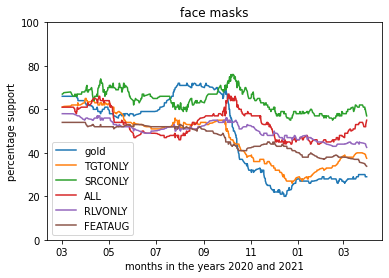

In [487]:
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m"))
ax.plot_date(time_data_facemask, graph_data_facemask_gold, fmt="-", label="gold")
ax.plot_date(time_data_facemask, graph_data_facemask_FFT, fmt="-", label="TGTONLY")
ax.plot_date(time_data_facemask, graph_data_facemask_DFT, fmt="-", label="SRCONLY")
ax.plot_date(time_data_facemask, graph_data_facemask_EFT, fmt="-", label="ALL")
ax.plot_date(time_data_facemask, graph_data_facemask_RLV, fmt="-", label="RLVONLY")
ax.plot_date(time_data_facemask, graph_data_facemask_EXG, fmt="-", label="FEATAUG")
plt.ylim(0, 100)
plt.title("face masks")
plt.xlabel("months in the years 2020 and 2021")
plt.ylabel("percentage support")
plt.legend()
plt.savefig("clin-facemask.png")
plt.show()

### 8.2 Testing

In [488]:
graph_data_testing_gold = make_graph_data(get_labels_from_fasttext_data(fasttext_data_list_testing))
graph_data_testing_FFT = make_graph_data(get_prediction_labels_list(read_fasttext_data(f"predictionLabelsTestTTT-{DIM}-{EPOCH}-{LR}.pickle")))
graph_data_testing_DFT = make_graph_data(get_prediction_labels_list([model_distance.predict(fasttext_data_list_testing)]))
graph_data_testing_EFT = make_graph_data(get_prediction_labels_list(read_fasttext_data(f"predictionLabelsTestETT-{DIM}-{EPOCH}-{LR}.pickle")))
graph_data_testing_RLV = make_graph_data(read_fasttext_data("predictionLabelsTestTTT-300-200-0.2.pickle.RLV-300-200-0.2.pickle"))
graph_data_testing_EXG = make_graph_data(read_fasttext_data("predictionLabelsTestTTT-300-200-0.2.pickle.EXG-300-200-0.2.pickle"))

In [489]:
(get_r_value(graph_data_testing_gold, graph_data_testing_FFT), 
 get_r_value(graph_data_testing_gold, graph_data_testing_DFT),
 get_r_value(graph_data_testing_gold, graph_data_testing_EFT),
 get_r_value(graph_data_testing_gold, graph_data_testing_RLV),
 get_r_value(graph_data_testing_gold, graph_data_testing_EXG)
)

(0.949, 0.819, 0.882, 0.856, 0.848)

In [490]:
(absolute_difference(graph_data_testing_gold, graph_data_testing_FFT), 
 absolute_difference(graph_data_testing_gold, graph_data_testing_DFT),
 absolute_difference(graph_data_testing_gold, graph_data_testing_EFT),
 absolute_difference(graph_data_testing_gold, graph_data_testing_RLV),
 absolute_difference(graph_data_testing_gold, graph_data_testing_EXG)
)

(0.093, 0.169, 0.097, 0.087, 0.102)

In [491]:
TIME_FILE = "csv/time_data.testing-202003-202012.csv"

time_data_testing_all = pd.read_csv(TIME_FILE, index_col="id_str").to_dict(orient="series")['created_at']
time_data_testing = []
for tweet_id in tweet_ids_testing:
    try:
        time_data_testing.append(datetime.datetime.strptime(time_data_testing_all[tweet_id], "%a %b %d %H:%M:%S %z %Y"))
    except:
        print(f"key not found {tweet_id}")

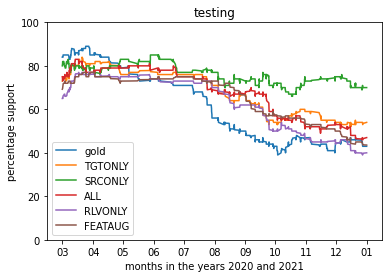

In [492]:
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m"))
ax.plot_date(time_data_testing, graph_data_testing_gold, fmt="-", label="gold")
ax.plot_date(time_data_testing, graph_data_testing_FFT, fmt="-", label="TGTONLY")
ax.plot_date(time_data_testing, graph_data_testing_DFT, fmt="-", label="SRCONLY")
ax.plot_date(time_data_testing, graph_data_testing_EFT, fmt="-", label="ALL")
ax.plot_date(time_data_testing, graph_data_testing_RLV, fmt="-", label="RLVONLY")
ax.plot_date(time_data_testing, graph_data_testing_EXG, fmt="-", label="FEATAUG")
plt.ylim(0, 100)
plt.title("testing")
plt.xlabel("months in the years 2020 and 2021")
plt.ylabel("percentage support")
plt.legend()
plt.savefig("clin-testing.png")
plt.show()

### 8.3 Vaccination

In [493]:
graph_data_vaccination_gold = make_graph_data(get_labels_from_fasttext_data(fasttext_data_list_vaccination))
graph_data_vaccination_FFT = make_graph_data(get_prediction_labels_list(read_fasttext_data(f"predictionLabelsTestVVT-{DIM}-{EPOCH}-{LR}.pickle")))
graph_data_vaccination_DFT = make_graph_data(get_prediction_labels_list([model_distance.predict(fasttext_data_list_vaccination)]))
graph_data_vaccination_EFT = make_graph_data(get_prediction_labels_list(read_fasttext_data(f"predictionLabelsTestEVT-{DIM}-{EPOCH}-{LR}.pickle")))
graph_data_vaccination_RLV = make_graph_data(read_fasttext_data("predictionLabelsTestVVT-300-200-0.2.pickle.RLV-300-200-0.2.pickle"))
graph_data_vaccination_EXG = make_graph_data(read_fasttext_data("predictionLabelsTestVVT-300-200-0.2.pickle.EXG-300-200-0.2.pickle"))

In [494]:
(get_r_value(graph_data_vaccination_gold, graph_data_vaccination_FFT), 
 get_r_value(graph_data_vaccination_gold, graph_data_vaccination_DFT),
 get_r_value(graph_data_vaccination_gold, graph_data_vaccination_EFT),
 get_r_value(graph_data_vaccination_gold, graph_data_vaccination_RLV),
 get_r_value(graph_data_vaccination_gold, graph_data_vaccination_EXG)
)

(0.361, 0.586, 0.592, 0.528, -0.824)

In [495]:
(absolute_difference(graph_data_vaccination_gold, graph_data_vaccination_FFT), 
 absolute_difference(graph_data_vaccination_gold, graph_data_vaccination_DFT),
 absolute_difference(graph_data_vaccination_gold, graph_data_vaccination_EFT),
 absolute_difference(graph_data_vaccination_gold, graph_data_vaccination_RLV),
 absolute_difference(graph_data_vaccination_gold, graph_data_vaccination_EXG)
)

(0.078, 0.26, 0.149, 0.107, 0.102)

In [496]:
TIME_FILE = "csv/time_data.vaccin-202001-202101-1000.csv"

time_data_vaccination_all = pd.read_csv(TIME_FILE, index_col="id_str").to_dict(orient="series")['created_at']
time_data_vaccination = []
for tweet_id in tweet_ids_vaccination:
    try:
        time_data_vaccination.append(datetime.datetime.strptime(time_data_vaccination_all[tweet_id], "%a %b %d %H:%M:%S %z %Y"))
    except:
        print(f"key not found {tweet_id}")

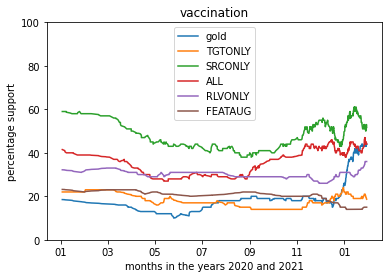

In [497]:
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m"))
ax.plot_date(time_data_vaccination, graph_data_vaccination_gold, fmt="-", label="gold")
ax.plot_date(time_data_vaccination, graph_data_vaccination_FFT, fmt="-", label="TGTONLY")
ax.plot_date(time_data_vaccination, graph_data_vaccination_DFT, fmt="-", label="SRCONLY")
ax.plot_date(time_data_vaccination, graph_data_vaccination_EFT, fmt="-", label="ALL")
ax.plot_date(time_data_vaccination, graph_data_vaccination_RLV, fmt="-", label="RLVONLY")
ax.plot_date(time_data_vaccination, graph_data_vaccination_EXG, fmt="-", label="FEATAUG")
plt.ylim(0, 100)
plt.title("vaccination")
plt.xlabel("months in the years 2020 and 2021")
plt.ylabel("percentage support")
plt.legend()
plt.savefig("clin-vaccination.png")
plt.show()

## Old code

In [147]:
predictionLabelsTestDT = read_fasttext_data("predictionLabelsTestDT.pickle")
predictionLabelsTestTT = read_fasttext_data("predictionLabelsTestTT.pickle")
predictionLabelsTestET = read_fasttext_data("predictionLabelsTestET.pickle")

In [148]:
time_factor = 3
data_predicted_dt = make_data_predicted(predictionLabelsTestDT, tweet_ids_testing, time_factor=time_factor)
data_predicted_tt = make_data_predicted(predictionLabelsTestTT, tweet_ids_testing, time_factor=time_factor)
data_predicted_et = make_data_predicted(predictionLabelsTestET, tweet_ids_testing, time_factor=time_factor)

In [149]:
gold = []
for tweet in fasttext_data_list_testing:
    gold.append(tweet.split()[0])

data_gold = {}
for i in range(0, len(tweet_ids_testing)):
    summary = str(tweet_ids_testing[i])[0:time_factor]
    if summary not in data_gold:
        data_gold[summary] = []
    data_gold[summary].append(gold[i])

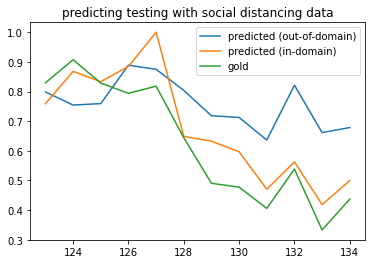

In [150]:
plot_data_predicted_dt = convert(data_predicted_dt)
plot_data_predicted_tt = convert(data_predicted_tt)
plot_data_predicted_et = convert(data_predicted_et)
plot_data_gold = convert(data_gold)

x_gold = [x[0] for x in plot_data_gold]
y_gold = [x[1] for x in plot_data_gold]
x_dt = [x[0] for x in plot_data_predicted_dt]
y_dt = [x[1] for x in plot_data_predicted_dt]
x_tt = [x[0] for x in plot_data_predicted_tt]
y_tt = [x[1] for x in plot_data_predicted_tt]
x_et = [x[0] for x in plot_data_predicted_et]
y_et = [x[1] for x in plot_data_predicted_et]
plt.plot(x_dt, y_dt, label="predicted (out-of-domain)", c="C0")
plt.plot(x_tt, y_tt, label="predicted (in-domain)", c="C1")
plt.plot(x_gold, y_gold, label="gold", c="C2")
#plt.plot(x_et, y_et, label="predicted (added data)", c="C3")
plt.legend()
plt.title("predicting testing with social distancing data")
plt.savefig("distancing-to-testing.png")
plt.show()

### Inflate predictions (old)

In [151]:
freqs = get_freqs(gold)
print(freqs)
print(freqs['__label__REJECTS']/freqs['__label__SUPPORTS'])

{'__label__SUPPORTS': 0.28789161727349705, '__label__IRRELEVANT': 0.5342929720575783, '__label__REJECTS': 0.17781541066892464}
0.6176470588235294


In [152]:
predictionLabelsTestDT = read_fasttext_data("predictionLabelsTestDT.pickle")

In [153]:
FACTOR = 0.7957

predictionLabelsTestDTinflated = list(predictionLabelsTestDT)
freqs = get_freqs([y[0] for x in inflate_plus(predictionLabelsTestDTinflated, '__label__REJECTS', '__label__SUPPORTS', FACTOR) for y in x[0]])
print(freqs)
print(freqs['__label__REJECTS']/freqs['__label__SUPPORTS'])

{'__label__REJECTS': 0.26418289585097376, '__label__SUPPORTS': 0.42675698560541914, '__label__IRRELEVANT': 0.3090601185436071}
0.6190476190476191


In [154]:
data_predicted_dt_inflated = make_data_predicted(inflate(predictionLabelsTestDTinflated, 
                                                         '__label__REJECTS', 
                                                         '__label__SUPPORTS', 
                                                         FACTOR), 
                                                         tweet_ids_testing, 
                                                         time_factor=time_factor)

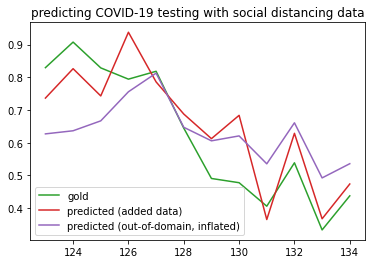

In [155]:
plot_data_predicted_dt = convert(data_predicted_dt)
plot_data_predicted_tt = convert(data_predicted_tt)
plot_data_predicted_et = convert(data_predicted_et)
plot_data_predicted_dt_inflated = convert(data_predicted_dt_inflated)
plot_data_gold = convert(data_gold)

x_gold = [x[0] for x in plot_data_gold]
y_gold = [x[1] for x in plot_data_gold]
x_dt = [x[0] for x in plot_data_predicted_dt]
y_dt = [x[1] for x in plot_data_predicted_dt]
x_tt = [x[0] for x in plot_data_predicted_tt]
y_tt = [x[1] for x in plot_data_predicted_tt]
x_et = [x[0] for x in plot_data_predicted_et]
y_et = [x[1] for x in plot_data_predicted_et]
x_dt_inflated = [x[0] for x in plot_data_predicted_dt_inflated]
y_dt_inflated = [x[1] for x in plot_data_predicted_dt_inflated]

#plt.plot(x_dt, y_dt, label="predicted (out-of-domain)", c="C0")
#plt.plot(x_tt, y_tt, label="predicted (in-domain)", c="C1")
plt.plot(x_gold, y_gold, label="gold", c="C2")
plt.plot(x_et, y_et, label="predicted (added data)", c="C3")
plt.plot(x_dt_inflated, y_dt_inflated, label="predicted (out-of-domain, inflated)", c="C4")

plt.legend()
plt.title("predicting COVID-19 testing with social distancing data")
plt.savefig("distancing-to-testing.png")
plt.show()

### Removing domain-dependent words (old)

In [70]:
predictionCountsValidationDTD, predictionLabelsValidationDTD, predictionCountsTestDTD, predictionLabelsTestDTD = \
        runFasttext(fasttext_data_list_distance, fasttext_data_list_testing, squealFlag=False, dim=300)

0 cases: 118; precision: 0.364; recall: 0.364; fraction: 0.462
1 cases: 118; precision: 0.407; recall: 0.407; fraction: 0.614
2 cases: 118; precision: 0.432; recall: 0.432; fraction: 0.719
3 cases: 118; precision: 0.390; recall: 0.390; fraction: 0.465
4 cases: 118; precision: 0.331; recall: 0.331; fraction: 0.626
5 cases: 119; precision: 0.387; recall: 0.387; fraction: 0.553
6 cases: 118; precision: 0.432; recall: 0.432; fraction: 0.194
7 cases: 118; precision: 0.390; recall: 0.390; fraction: 0.099
8 cases: 118; precision: 0.432; recall: 0.432; fraction: 0.991
9 cases: 118; precision: 0.314; recall: 0.314; fraction: 1.359
 col_0                __label__IRRELEVANT  __label__REJECTS  __label__SUPPORTS
row_0                                                                        
__label__IRRELEVANT                  197                98                336
__label__REJECTS                      70                51                 89
__label__SUPPORTS                     92                3

In [156]:
def count_tokens(tweet_list):
    counts = {}
    for tweet in tweet_list:
        for token in tweet.split()[1:]:
            if not token in counts:
                counts[token] = 0
            counts[token] += 1
    return(counts)

In [159]:
counts_train = count_tokens(fasttext_data_list_distance)
counts_test = count_tokens(fasttext_data_list_testing)
counts_train_total = sum(counts_train.values())
counts_test_total = sum(counts_test.values())
print(counts_train_total, counts_test_total)

196888 52387


In [157]:
def remove_infrequent_tokens(tweet_list_in, counts_train, counts_test, counts_train_total, counts_test_total, minimum_frequency=0):
    tweet_list_out = []
    token_count = 0
    for tweet in tweet_list_in:
        accepted_tokens = []
        tweet_tokens = tweet.split()
        for token in tweet_tokens[1:]:
            if token in counts_train and token in counts_test and \
               counts_train[token] / counts_train_total > minimum_frequency and \
               counts_test[token] / counts_test_total > minimum_frequency:
                accepted_tokens.append(token)
        token_count += 1 + len(accepted_tokens)
        if len(accepted_tokens) == 0:
            accepted_tokens = [ "DUMMY" ]
        tweet_list_out.append(" ".join(tweet_tokens[:1]+accepted_tokens))
    print(token_count)
    return(tweet_list_out)

In [160]:
MINFREQ = 0.0002
fasttext_data_list_distance_filtered = remove_infrequent_tokens(fasttext_data_list_distance, counts_train, counts_test, counts_train_total, counts_test_total, minimum_frequency=MINFREQ)
fasttext_data_list_testing_filtered = remove_infrequent_tokens(fasttext_data_list_testing, counts_train, counts_test, counts_train_total, counts_test_total, minimum_frequency=MINFREQ)

137571
36390


In [71]:
if False:
    predictionCountsValidationDTD, predictionLabelsValidationDTD, predictionCountsTestDTD, predictionLabelsTestDTD = \
        runFasttext(fasttext_data_list_distance_filtered, fasttext_data_list_testing, squealFlag=False, dim=300, pretrainedVectors="twiqs-model-2020.vec")

In [72]:
if False:
    store_fasttext_data(predictionLabelsTestDTD, "predictionLabelsTestDTD0.0002A.pickle")

In [161]:
predictionLabelsTestDTD = read_fasttext_data("predictionLabelsTestDTD0.0002A.pickle")

|  method | train | test | accuracy | fraction | comment |
| ------- | ----- | ---- | -------- | -------- | ------- |
| none        | 196888 | 52387 | 0.385 | 0.478 | |
| M = 0       | 171520 | 49477 | 0.379 | 0.650 | |
| M = 0.00001 | 170682 | 48139 | 0.375 | 0.650 | |
| M = 0.0001  | 145771 | 39891 | 0.379 | 0.688 | |
| M = 0.0002  | 137571 | 36390 | 0.390 | 0.833 | |
| M = 0.0003  | 127440 | 34457 | 0.359 | 0.776 | |
| M = 0.0004  | 119718 | 32913 | 0.346 | 0.764 | |
| M = 0.001   |  99965 | 28123 | 0.327 | 0.186 | |
| M = 0.01    |  46634 | 12909 | 0.289 | 0.006 | |
| M = 0.1     |   5731 |  1181 | 0.288 | 0.000 | |
| M = 0       | 171520 | 52387 | 0.381 | 0.635 | |
| M = 0.00001 | 170682 | 52387 | 0.374 | 0.637 | |
| M = 0.0001  | 145771 | 52387 | 0.378 | 0.665 | |
| M = 0.0002  | 137571 | 52387 | 0.395 | 0.860 | |
| M = 0.0003  | 127440 | 52387 | 0.358 | 0.764 | |
| M = 0.0004  | 119718 | 52387 | 0.345 | 0.769 | |
| M = 0.001   |  99965 | 52387 | 0.324 | 0.193 | |
| M = 0.01    |  46634 | 52387 | 0.290 | 0.007 | |
| M = 0.1     |   5731 | 52387 | 0.288 | 0.000 | |
| M = 0       | 171520 | 49477 | 0.393 | 0.736 | +model |
| M = 0.0002  | 137571 | 36390 | 0.385 | 0.841 | +model |
| M = 0.0002  | 137571 | 52387 | 0.380 | 0.734 | +model |

In [162]:
data_predicted_dtd = make_data_predicted(predictionLabelsTestDTD, tweet_ids_testing, time_factor=time_factor)

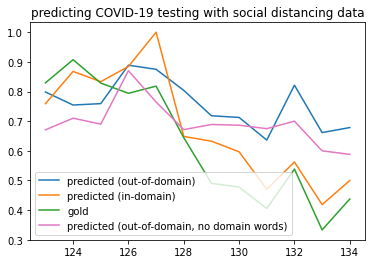

In [163]:
plot_data_predicted_dt = convert(data_predicted_dt)
plot_data_predicted_tt = convert(data_predicted_tt)
plot_data_predicted_et = convert(data_predicted_et)
plot_data_predicted_dt_inflated = convert(data_predicted_dt_inflated)
plot_data_predicted_dtd = convert(data_predicted_dtd)
plot_data_gold = convert(data_gold)

x_gold = [x[0] for x in plot_data_gold]
y_gold = [x[1] for x in plot_data_gold]
x_dt = [x[0] for x in plot_data_predicted_dt]
y_dt = [x[1] for x in plot_data_predicted_dt]
x_tt = [x[0] for x in plot_data_predicted_tt]
y_tt = [x[1] for x in plot_data_predicted_tt]
x_et = [x[0] for x in plot_data_predicted_et]
y_et = [x[1] for x in plot_data_predicted_et]
x_dt_inflated = [x[0] for x in plot_data_predicted_dt_inflated]
y_dt_inflated = [x[1] for x in plot_data_predicted_dt_inflated]
x_dtd = [x[0] for x in plot_data_predicted_dtd]
y_dtd = [x[1] for x in plot_data_predicted_dtd]

plt.plot(x_dt, y_dt, label="predicted (out-of-domain)", c="C0")
plt.plot(x_tt, y_tt, label="predicted (in-domain)", c="C1")
plt.plot(x_gold, y_gold, label="gold", c="C2")
#plt.plot(x_et, y_et, label="predicted (added data)", c="C3")
#plt.plot(x_dt_inflated, y_dt_inflated, label="predicted (out-of-domain, inflated)", c="C4")
plt.plot(x_dtd, y_dtd, label="predicted (out-of-domain, no domain words)", c="C6")

plt.legend()
plt.title("predicting COVID-19 testing with social distancing data")
plt.savefig("distancing-to-testing.png")
plt.show()

### Training and testing on only relevant data (old)

In [164]:
fasttext_data_list_distance_relevant = [ line for line in fasttext_data_list_distance if not re.search("^__label__IRRELEVANT", line) ]
len(fasttext_data_list_distance_relevant)

4364

In [77]:
if False:
    predictionCountsValidationT, predictionLabelsValidationT, predictionCountsTestT, predictionLabelsTestT = \
        runFasttext(fasttext_data_list_testing, fasttext_data_list_testing, squealFlag=False, dim=300, pretrainedVectors="twiqs-model-2020.vec")

0 cases: 118; precision: 0.576; recall: 0.576; fraction: 0.604
1 cases: 118; precision: 0.585; recall: 0.585; fraction: 1.217
2 cases: 118; precision: 0.636; recall: 0.636; fraction: 1.166
3 cases: 118; precision: 0.593; recall: 0.593; fraction: 0.697
4 cases: 118; precision: 0.610; recall: 0.610; fraction: 1.067
5 cases: 119; precision: 0.580; recall: 0.580; fraction: 0.549
6 cases: 118; precision: 0.576; recall: 0.576; fraction: 0.441
7 cases: 118; precision: 0.695; recall: 0.695; fraction: 0.588
8 cases: 118; precision: 0.525; recall: 0.525; fraction: 2.698
9 cases: 118; precision: 0.576; recall: 0.576; fraction: 0.549
 col_0                __label__IRRELEVANT  __label__REJECTS  __label__SUPPORTS
row_0                                                                        
__label__IRRELEVANT                  442                50                139
__label__REJECTS                      85                95                 30
__label__SUPPORTS                    152                2

In [78]:
if False:
    store_fasttext_data(predictionLabelsTestT, "predictionLabelsTestT.pickle")

In [165]:
predictionLabelsTestT = read_fasttext_data("predictionLabelsTestT.pickle")

In [166]:
fasttext_data_list_testing_relevant = []
i = 0
for fold in predictionLabelsTestT:
    for prediction_order_list in fold[0]:
        if prediction_order_list[0] != "__label__IRRELEVANT":
            tweet = re.sub("^__label__IRRELEVANT", "__label__SUPPORTS", fasttext_data_list_testing[i])
            fasttext_data_list_testing_relevant.append(tweet)
        i += 1

In [167]:
len(fasttext_data_list_distance_relevant), len(fasttext_data_list_testing_relevant)

(4364, 502)

In [181]:
if False:
    predictionCountsValidationDTR, predictionLabelsValidationDTR, predictionCountsTestDTR, predictionLabelsTestDTR = \
        runFasttext(fasttext_data_list_distance_relevant, fasttext_data_list_testing_relevant, squealFlag=False, dim=300, pretrainedVectors="twiqs-model-2020.vec")

0 cases: 50; precision: 0.660; recall: 0.660; fraction: 2.144
1 cases: 50; precision: 0.800; recall: 0.800; fraction: 0.826
2 cases: 51; precision: 0.725; recall: 0.725; fraction: 0.779
3 cases: 50; precision: 0.820; recall: 0.820; fraction: 1.092
4 cases: 50; precision: 0.660; recall: 0.660; fraction: 2.452
5 cases: 50; precision: 0.840; recall: 0.840; fraction: 1.568
6 cases: 50; precision: 0.760; recall: 0.760; fraction: 1.185
7 cases: 51; precision: 0.627; recall: 0.627; fraction: 0.664
8 cases: 50; precision: 0.740; recall: 0.740; fraction: 1.631
9 cases: 50; precision: 0.580; recall: 0.580; fraction: 6.000
 col_0              __label__REJECTS  __label__SUPPORTS
row_0                                                 
__label__REJECTS                 71                 54
__label__SUPPORTS                86                291
cases: 502; precision: 0.721; recall: 0.721; fraction: 1.372


In [182]:
if False:
    store_fasttext_data(predictionLabelsTestDTR, "predictionLabelsTestDTR.pickle")

In [183]:
predictionLabelsTestDTR = read_fasttext_data("predictionLabelsTestDTR.pickle")

In [184]:
predictionLabelsTestDTRrestored = []
fold_count = 0
for fold in predictionLabelsTestT:
    predictionLabelsTestDTRrestored.append(([[]]))
    tweet_count = 0
    for prediction_order_list in fold[0]:
        if prediction_order_list[0] == "__label__IRRELEVANT":
            predictionLabelsTestDTRrestored[-1][0].append(prediction_order_list)
        else:
            if tweet_count >= len(predictionLabelsTestDTR[fold_count][0]):
                break
            predictionLabelsTestDTRrestored[-1][0].append(predictionLabelsTestDTR[fold_count][0][tweet_count])
            tweet_count += 1
    for i in range(len(predictionLabelsTestDTRrestored[-1][0]), len(fold[0])):
        predictionLabelsTestDTRrestored[-1][0].append(fold[0][i])
    fold_count += 1
sum([len(fold[0]) for fold in predictionLabelsTestDTRrestored])

1181

In [185]:
data_predicted_dtr = make_data_predicted(predictionLabelsTestDTRrestored, tweet_ids_testing, time_factor=time_factor)

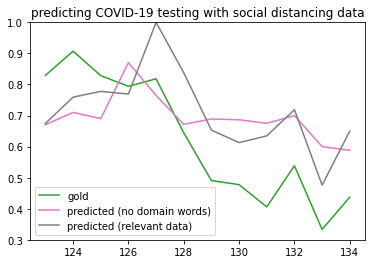

In [186]:
plot_data_predicted_dt = convert(data_predicted_dt)
plot_data_predicted_tt = convert(data_predicted_tt)
plot_data_predicted_et = convert(data_predicted_et)
plot_data_predicted_dt_inflated = convert(data_predicted_dt_inflated)
plot_data_predicted_dtd = convert(data_predicted_dtd)
plot_data_predicted_dtr = convert(data_predicted_dtr)
plot_data_gold = convert(data_gold)

x_gold = [x[0] for x in plot_data_gold]
y_gold = [x[1] for x in plot_data_gold]
x_dt = [x[0] for x in plot_data_predicted_dt]
y_dt = [x[1] for x in plot_data_predicted_dt]
x_tt = [x[0] for x in plot_data_predicted_tt]
y_tt = [x[1] for x in plot_data_predicted_tt]
x_et = [x[0] for x in plot_data_predicted_et]
y_et = [x[1] for x in plot_data_predicted_et]
x_dt_inflated = [x[0] for x in plot_data_predicted_dt_inflated]
y_dt_inflated = [x[1] for x in plot_data_predicted_dt_inflated]
x_dtd = [x[0] for x in plot_data_predicted_dtd]
y_dtd = [x[1] for x in plot_data_predicted_dtd]
x_dtr = [x[0] for x in plot_data_predicted_dtr]
y_dtr = [x[1] for x in plot_data_predicted_dtr]

plt.plot(x_gold, y_gold, label="gold", c="C2")
#plt.plot(x_dt, y_dt, label="predicted (out-of-domain)", c="C0")
#plt.plot(x_tt, y_tt, label="predicted (in-domain)", c="C1")
#lt.plot(x_et, y_et, label="predicted (added data)", c="C3")
#plt.plot(x_dt_inflated, y_dt_inflated, label="predicted (out-of-domain, inflated)", c="C4")
plt.plot(x_dtd, y_dtd, label="predicted (no domain words)", c="C6")
plt.plot(x_dtr, y_dtr, label="predicted (relevant data)", c="C7")

plt.ylim(0.3, 1.0)
plt.legend()
plt.title("predicting COVID-19 testing with social distancing data")
plt.savefig("distancing-to-testing.png")
plt.show()

### Numerical analysis of predictions (old)

In [187]:
plot_data_predicted_dt_dict = { x[0]:x[1] for x in plot_data_predicted_dt }
plot_data_predicted_tt_dict = { x[0]:x[1] for x in plot_data_predicted_tt }
plot_data_predicted_dt_inflated_dict = { x[0]:x[1] for x in plot_data_predicted_dt_inflated }
plot_data_predicted_dtd_dict = { x[0]:x[1] for x in plot_data_predicted_dtd }
plot_data_predicted_dtr_dict = { x[0]:x[1] for x in plot_data_predicted_dtr }
plot_data_predicted_et_dict = { x[0]:x[1] for x in plot_data_predicted_et }
plot_data_gold_dict = { x[0]:x[1] for x in plot_data_gold }

In [188]:
values_tt, values_gold_tt = get_common_key_values(plot_data_predicted_tt_dict, plot_data_gold_dict)
print("Pearson r correlation gold vs in-domain:", round(scipy.stats.linregress(np.array(values_gold_tt), np.array(values_tt)).rvalue, 2))
values_dt, values_gold_dt = get_common_key_values(plot_data_predicted_dt_dict, plot_data_gold_dict)
print("Pearson r correlation gold vs out-of-domain:", round(scipy.stats.linregress(np.array(values_gold_dt), np.array(values_dt)).rvalue, 2))
values_dt_inflated, values_gold_dt_inflated = get_common_key_values(plot_data_predicted_dt_inflated_dict, plot_data_gold_dict)
print("Pearson r correlation gold vs out-of-domain (inflated):", round(scipy.stats.linregress(np.array(values_gold_dt_inflated), np.array(values_dt_inflated)).rvalue, 2))
values_dtd, values_gold_dtd = get_common_key_values(plot_data_predicted_dtd_dict, plot_data_gold_dict)
print("Pearson r correlation gold vs out-of-domain (no domain data):", round(scipy.stats.linregress(np.array(values_gold_dtd), np.array(values_dtd)).rvalue, 2))
values_dtr, values_gold_dtr = get_common_key_values(plot_data_predicted_dtr_dict, plot_data_gold_dict)
print("Pearson r correlation gold vs out-of-domain (relevant data):", round(scipy.stats.linregress(np.array(values_gold_dtr), np.array(values_dtr)).rvalue, 2))
values_et, values_gold_et = get_common_key_values(plot_data_predicted_et_dict, plot_data_gold_dict)
print("Pearson r correlation gold vs out-of-domain (extra data):", round(scipy.stats.linregress(np.array(values_gold_et), np.array(values_et)).rvalue, 2))

Pearson r correlation gold vs in-domain: 0.93
Pearson r correlation gold vs out-of-domain: 0.72
Pearson r correlation gold vs out-of-domain (inflated): 0.73
Pearson r correlation gold vs out-of-domain (no domain data): 0.59
Pearson r correlation gold vs out-of-domain (relevant data): 0.71
Pearson r correlation gold vs out-of-domain (extra data): 0.87


In [189]:
print("absolute difference gold vs in-domain:", round(absolute_difference(values_gold_tt, values_tt), 2))
print("absolute difference gold vs out-of-domain:", round(absolute_difference(values_gold_dt, values_dt),2)) 
print("absolute difference gold vs out-of-domain (inflated):", round(absolute_difference(values_gold_dt_inflated, values_dt_inflated),2))
print("absolute difference gold vs out-of-domain (no domain data):", round(absolute_difference(values_gold_dtd, values_dtd),2))
print("absolute difference gold vs out-of-domain (relevant data):", round(absolute_difference(values_gold_dtr, values_dtr),2))
print("absolute difference gold vs out-of-domain (extra data):", round(absolute_difference(values_gold_et, values_et),2)) 

absolute difference gold vs in-domain: 0.07
absolute difference gold vs out-of-domain: 0.18
absolute difference gold vs out-of-domain (inflated): 0.12
absolute difference gold vs out-of-domain (no domain data): 0.16
absolute difference gold vs out-of-domain (relevant data): 0.15
absolute difference gold vs out-of-domain (extra data): 0.08
